In [18]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## Data Loading

### Helper Functions

In [24]:
def get_df_activity(activity):
    r = requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod WHERE activity %3D '{activity}'")

    df = pd.read_csv(io.StringIO(r.text), parse_dates=['timestamp'])
    return df.set_index('timestamp', drop=True)

In [25]:
def load_data(activity):
    try:
        # read locally if present
        df = pd.read_csv(f'{activity}.csv', parse_dates=['timestamp'])
        df = df.set_index('timestamp', drop=True)
        return df
    except FileNotFoundError:
        # get data from db
        df = get_df_activity(activity)
        df.to_csv(f'{activity}.csv')
        return df

In [26]:
def activities_call(activities, df, func):
    # filter df by activitty and call func with filtered df
    for activity in activities:
        df_activity = df[df['activity'] == activity]
        func(df_activity)

### Load Data

In [27]:
# Load activity data
df_sitzen = load_data('Sitzen')
df_stehen = load_data('Stehen')
df_laufen = load_data('Laufen')
df_rennen = load_data('Rennen')
df_treppenlaufen = load_data('Treppenlaufen')
df_velofahren = load_data('Velofahren')

In [28]:
# Get Sample Data from all activities
dfs = [df_sitzen, df_stehen, df_laufen, df_rennen, df_treppenlaufen, df_velofahren]

# take sample of n rows from all activities
sample_size = 2000
df_sample = pd.concat([df.sample(sample_size) for df in dfs])

# set category on activity
activities = ['Sitzen', 'Stehen', 'Laufen', 'Treppenlaufen', 'Rennen', 'Velofahren']
df_sample['activity'] = df_sample['activity'].astype('category')
df_sample['activity'] = df_sample["activity"].cat.set_categories(activities, ordered=True)

In [29]:
df_sample_accelerometer = df_sample[['Accelerometer_x', 'Accelerometer_y', 'Accelerometer_z', 'activity', 'filename', 'person']]
df_sample_accelerometer['activity'].unique()

['Sitzen', 'Stehen', 'Laufen', 'Rennen', 'Treppenlaufen', 'Velofahren']
Categories (6, object): ['Sitzen' < 'Stehen' < 'Laufen' < 'Treppenlaufen' < 'Rennen' < 'Velofahren']

## Looking at a specific activity

In [31]:
df_laufen_accelerometer = df_laufen[['Accelerometer_x', 'Accelerometer_y', 'Accelerometer_z', 'activity', 'filename', 'person']]
df_laufen_accelerometer.head()

,Accelerometer_x,Accelerometer_y,Accelerometer_z,activity,filename,person
timestamp,,,,,,
2023-02-27 15:02:14.080000+00:00,1.555,9.660,-0.650,Laufen,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran
2023-02-27 15:02:14.090000+00:00,1.564,9.657,-0.675,Laufen,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran
2023-02-27 15:02:14.100000+00:00,1.568,9.655,-0.694,Laufen,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran
2023-02-27 15:02:14.110000+00:00,1.566,9.654,-0.708,Laufen,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran
2023-02-27 15:02:14.120000+00:00,1.554,9.656,-0.715,Laufen,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran


<AxesSubplot: xlabel='timestamp'>

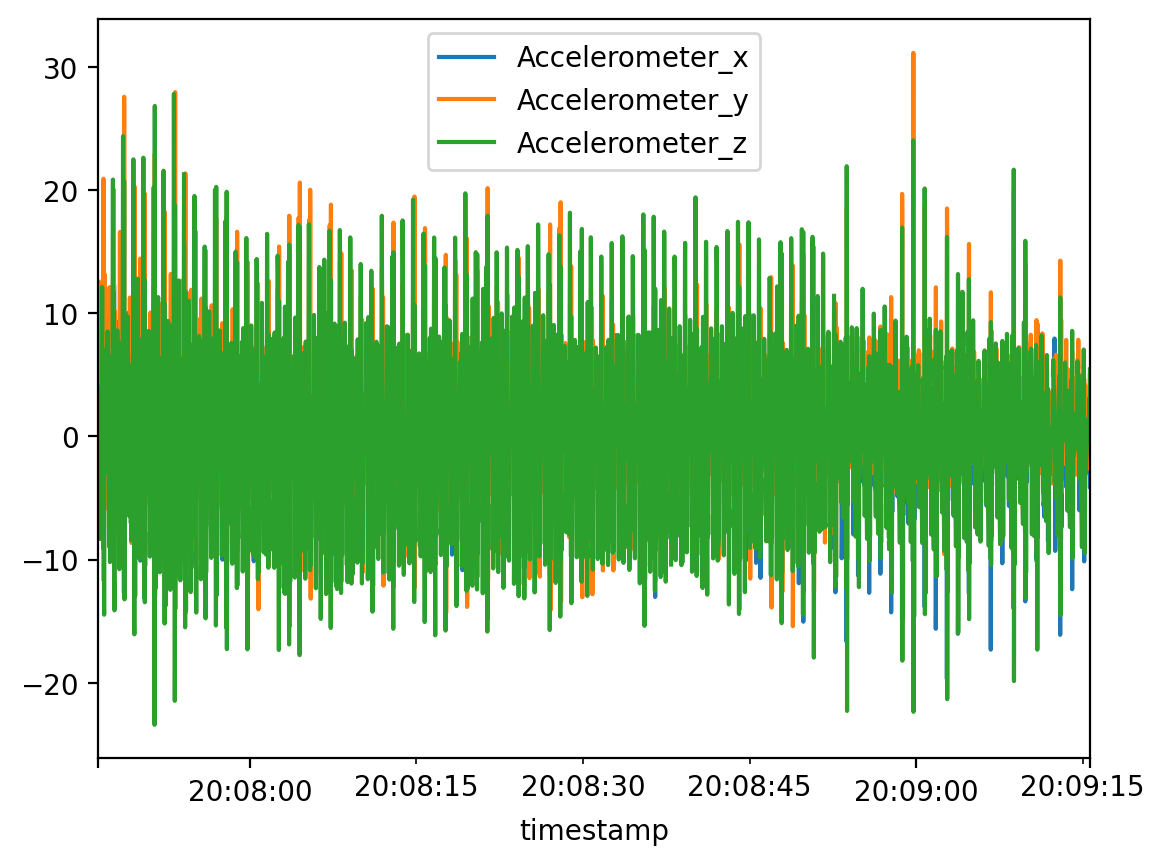

In [35]:
# filter for person = Yvo_Keller and filename = 01_iPhone14Pro-2023-02-28_20-07-35
df_laufen_sample = df_laufen_accelerometer[(df_laufen_accelerometer['person'] == 'Yvo_Keller') & (df_laufen_accelerometer['filename'] == '01_iPhone14Pro-2023-02-28_20-07-35')]
df_laufen_sample.plot()

## Find Frequency

In [36]:
# calculate frequency of samples
pd.infer_freq(df_laufen_sample.index)

'10L'

In [37]:
# put index into a column
df_laufen_sample_ts = df_laufen_sample.reset_index()

In [38]:
# new column with the difference between the current and the previous timestamp
df_laufen_sample_ts['diff'] = df_laufen_sample_ts['timestamp'].diff()

# convert diff to milliseconds
df_laufen_sample_ts['diff_ms'] = df_laufen_sample_ts['diff'].dt.total_seconds() * 1000

df_laufen_sample_ts.describe()

,Accelerometer_x,Accelerometer_y,Accelerometer_z,diff,diff_ms
count,8915.000000,8915.000000,8915.000000,8932,8932.0
mean,-0.045668,0.739031,-0.520945,0 days 00:00:00.010000,10.0
std,3.246609,5.127995,5.830181,0 days 00:00:00,0.0
min,-19.687101,-15.395956,-23.402189,0 days 00:00:00.010000,10.0
25%,-1.610500,-2.820489,-4.871030,0 days 00:00:00.010000,10.0
50%,0.421589,0.841482,-0.348321,0 days 00:00:00.010000,10.0
75%,2.052606,4.430501,3.060624,0 days 00:00:00.010000,10.0
max,12.317983,31.137680,27.809895,0 days 00:00:00.010000,10.0


**Notes**

Continuos frequency of **10ms** -> Makes sense, we are downsamling during the data import to our Timeseries DB to avoid many NaN values

## Compare Sensor Measurements based on Activity

### Helper functions

### Analyzing Accelerometer Measurements by Activity

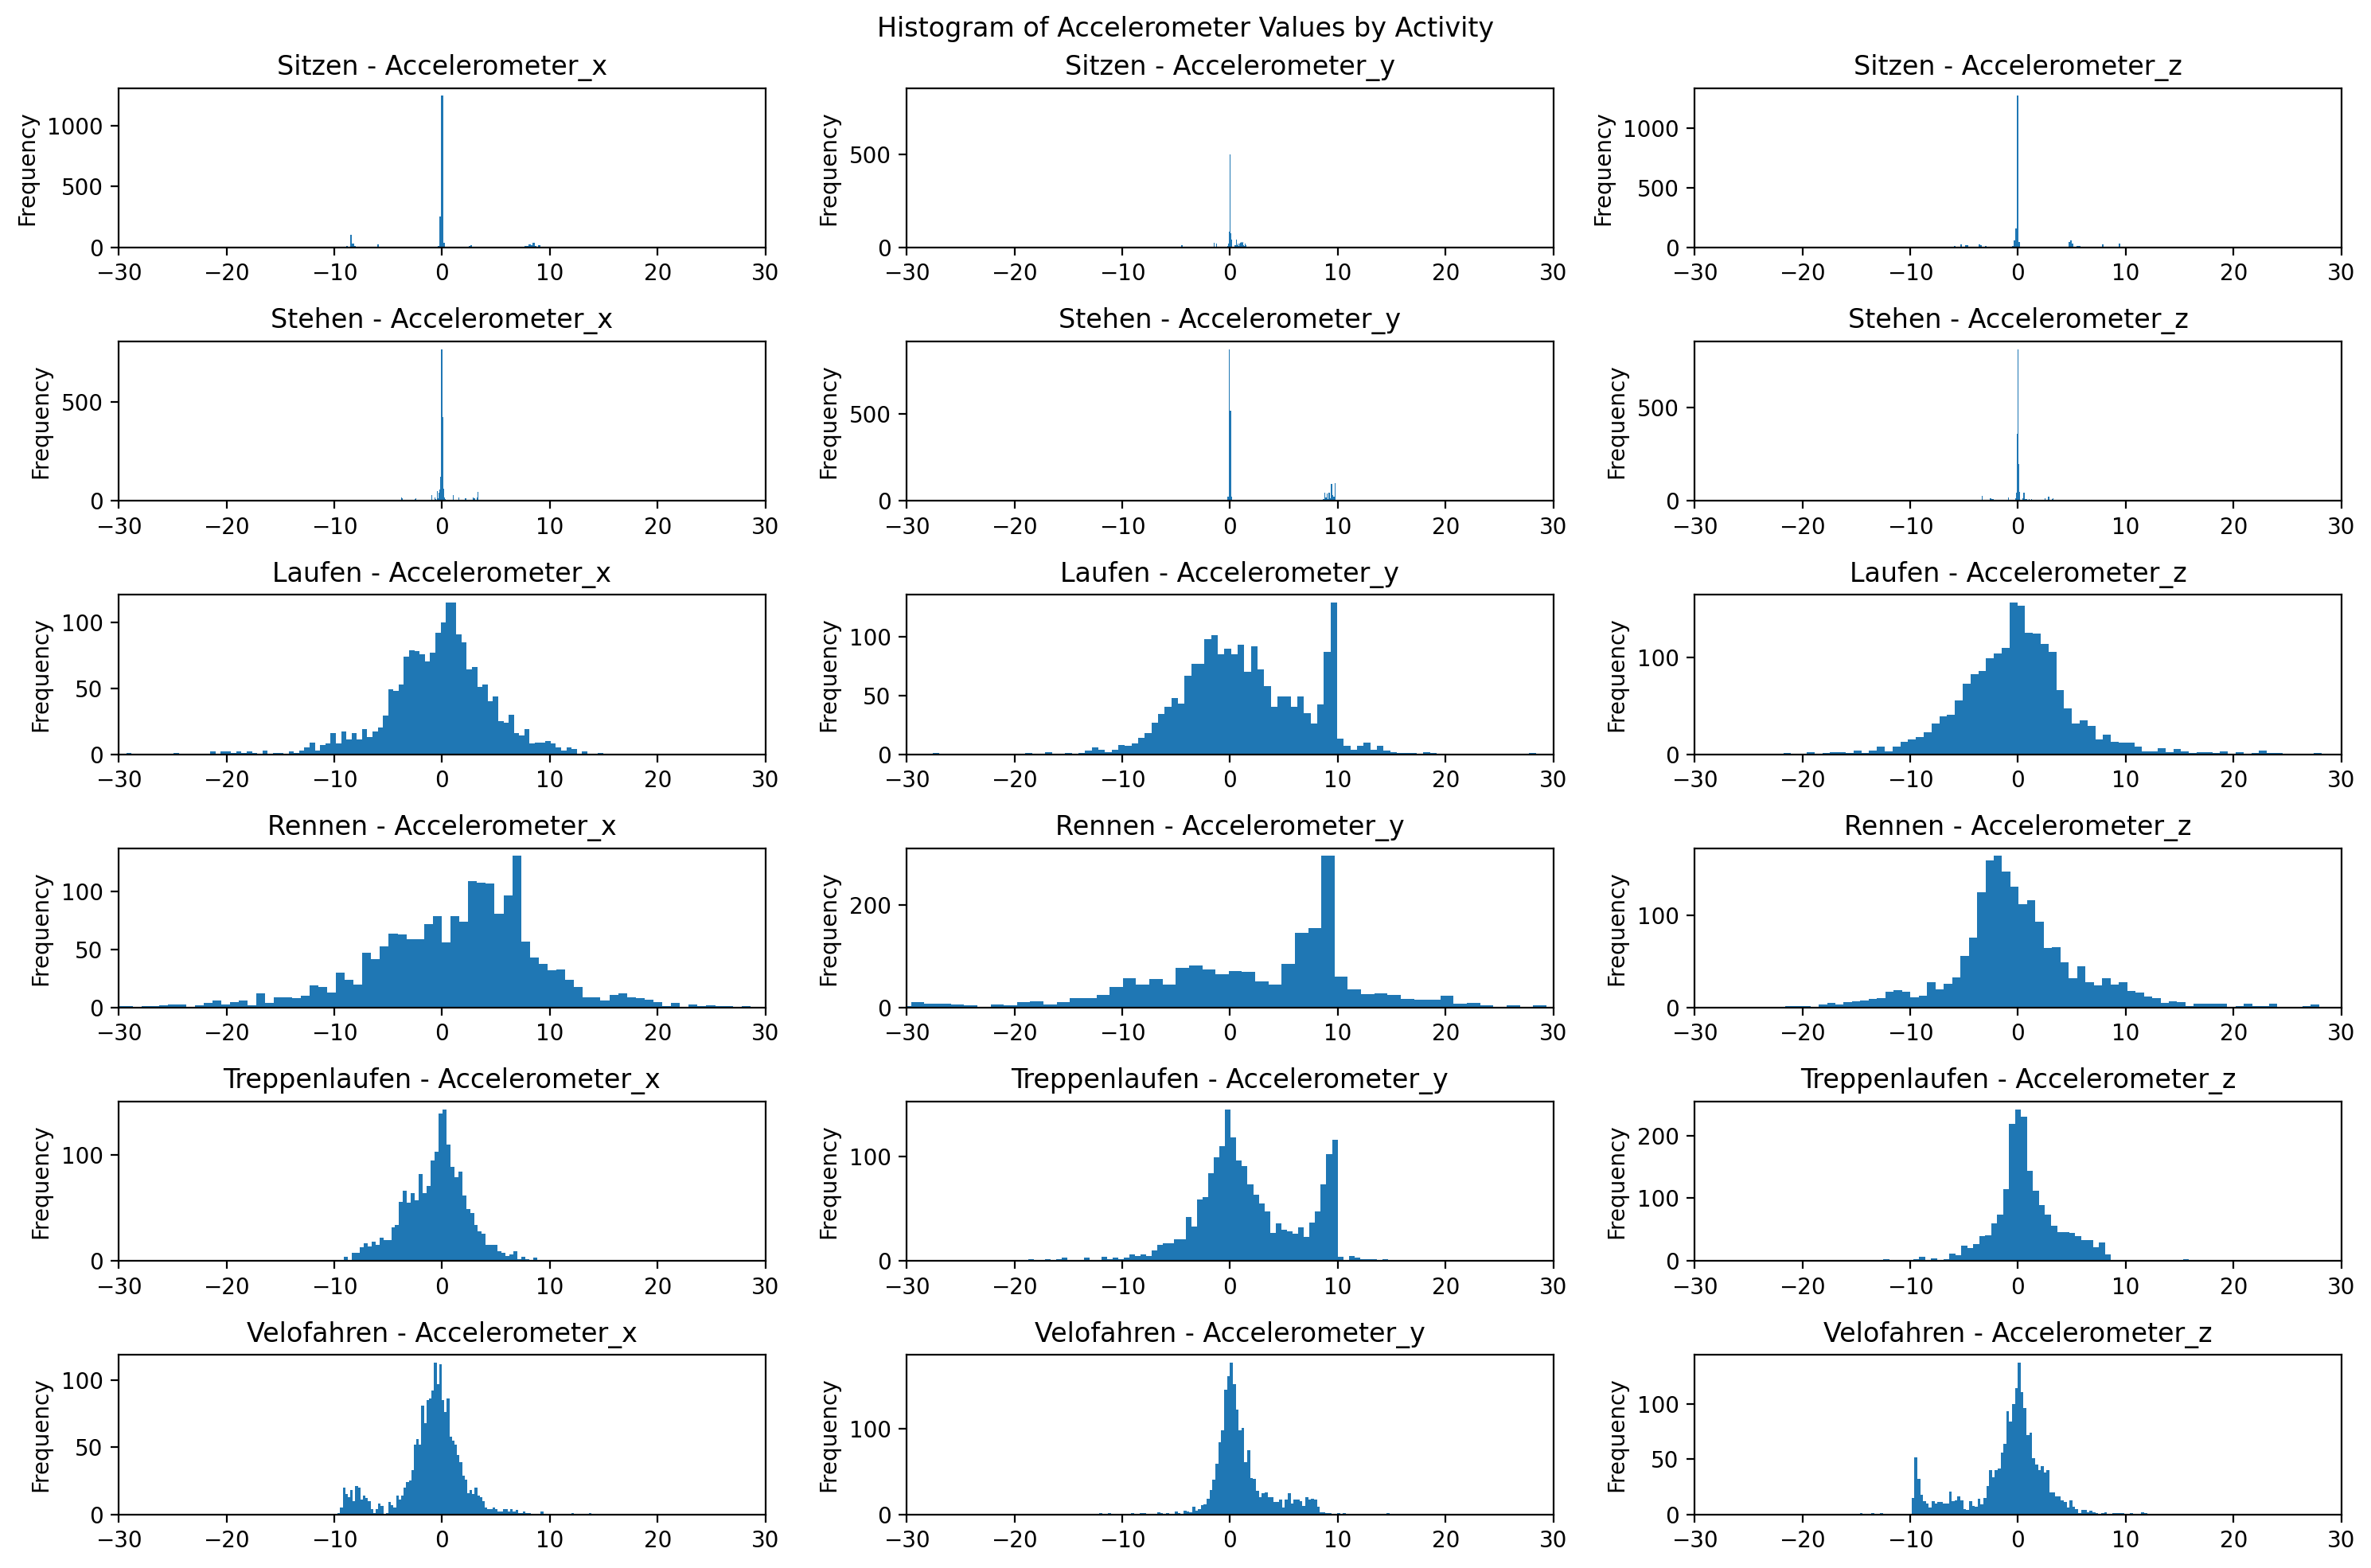

In [ ]:
# histogram of all accelerometer values by activity
fig, axs = plt.subplots(nrows=len(dfs), ncols=3, figsize=(15, 10))
for i, activity in enumerate(df_sample_accelerometer['activity'].unique()):
    for j, axis in enumerate(['Accelerometer_x', 'Accelerometer_y', 'Accelerometer_z']):
        df_sample_accelerometer[df_sample_accelerometer['activity'] == activity][axis].plot.hist(bins=100, ax=axs[i, j])
        # x-axis range -30 to +30
        axs[i, j].set_xlim(-30, 30)
        axs[i, j].set_title(f'{activity} - {axis}')

plt.suptitle('Histogram of Accelerometer Values by Activity')
plt.tight_layout()
plt.show()

**Notes**
- Eyeballing it is possible to differentiate between all the different activities by looking at the width and intensity of the distribution
- Sitzen and Stehen seem to be the most similar activities
- interesting distribution on the Accelerometer_y measurement for "Treppenlaufen"

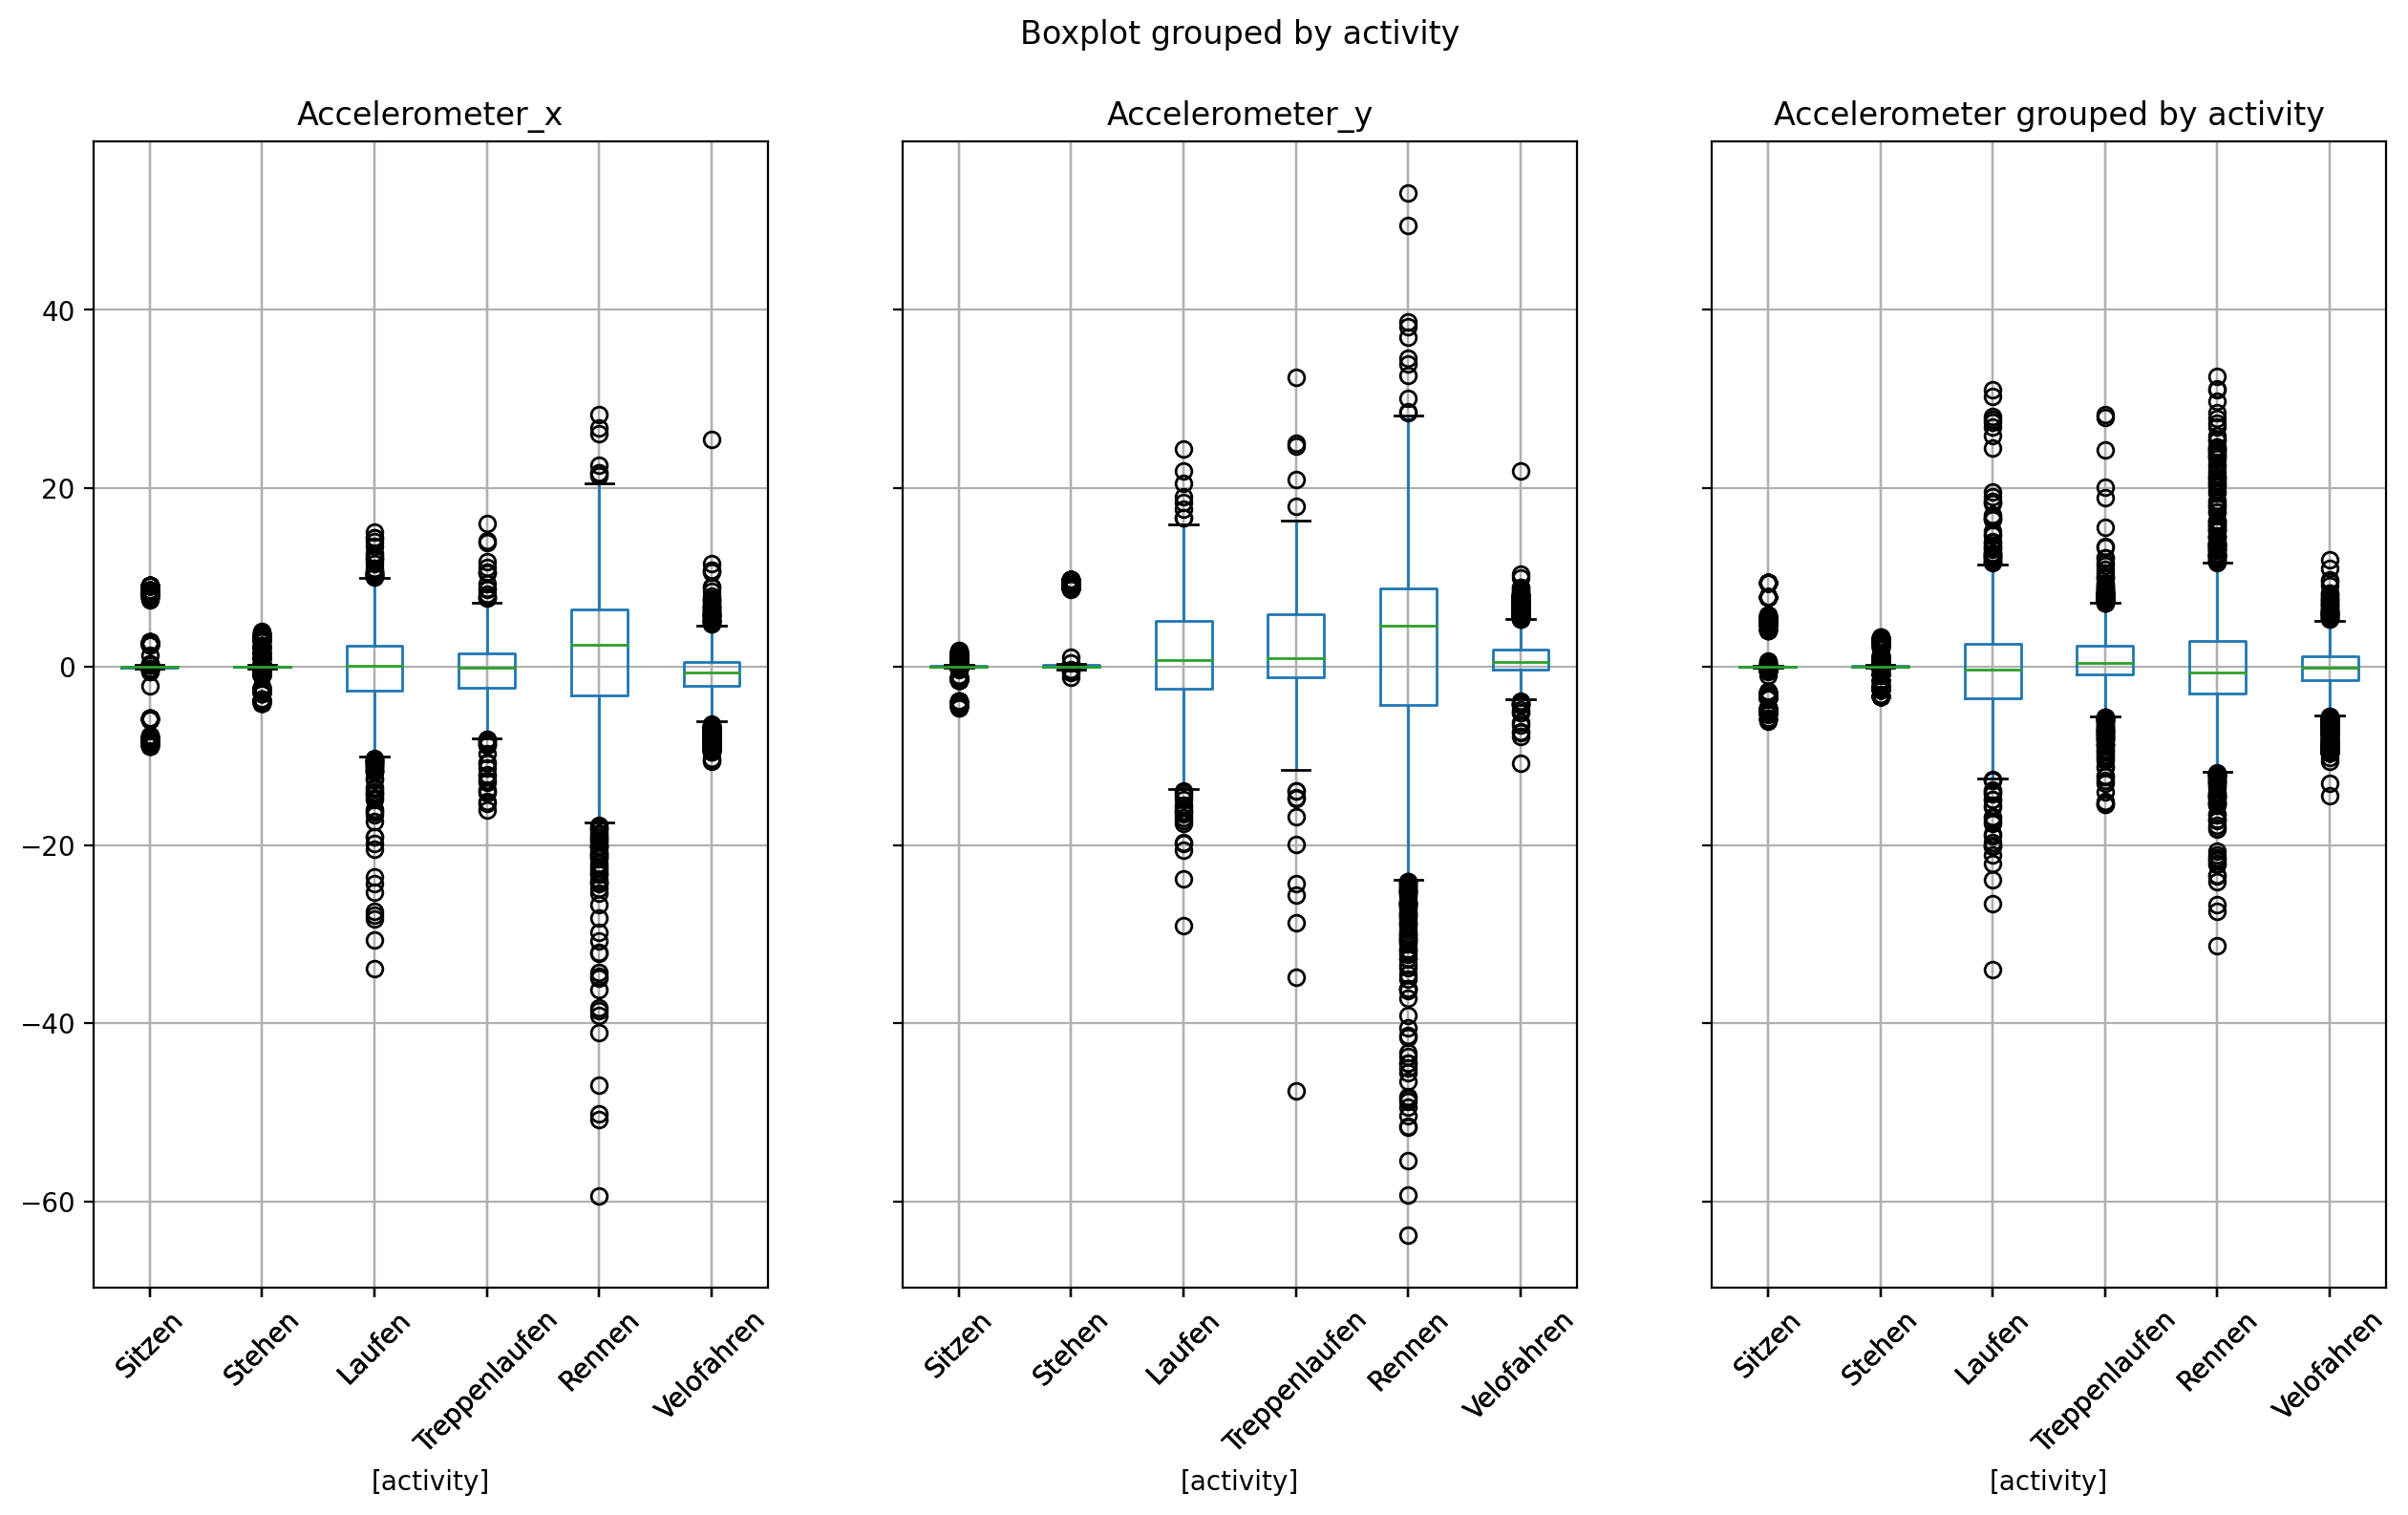

In [ ]:
# boxplot nach activity
df_sample_accelerometer.boxplot(by='activity', figsize=(15, 8), layout=(1, 3), rot=45)
plt.title('Accelerometer grouped by activity')
plt.show()

**Notes**

- Again, we can see the different distributions of the accelormeter measurements in each activity

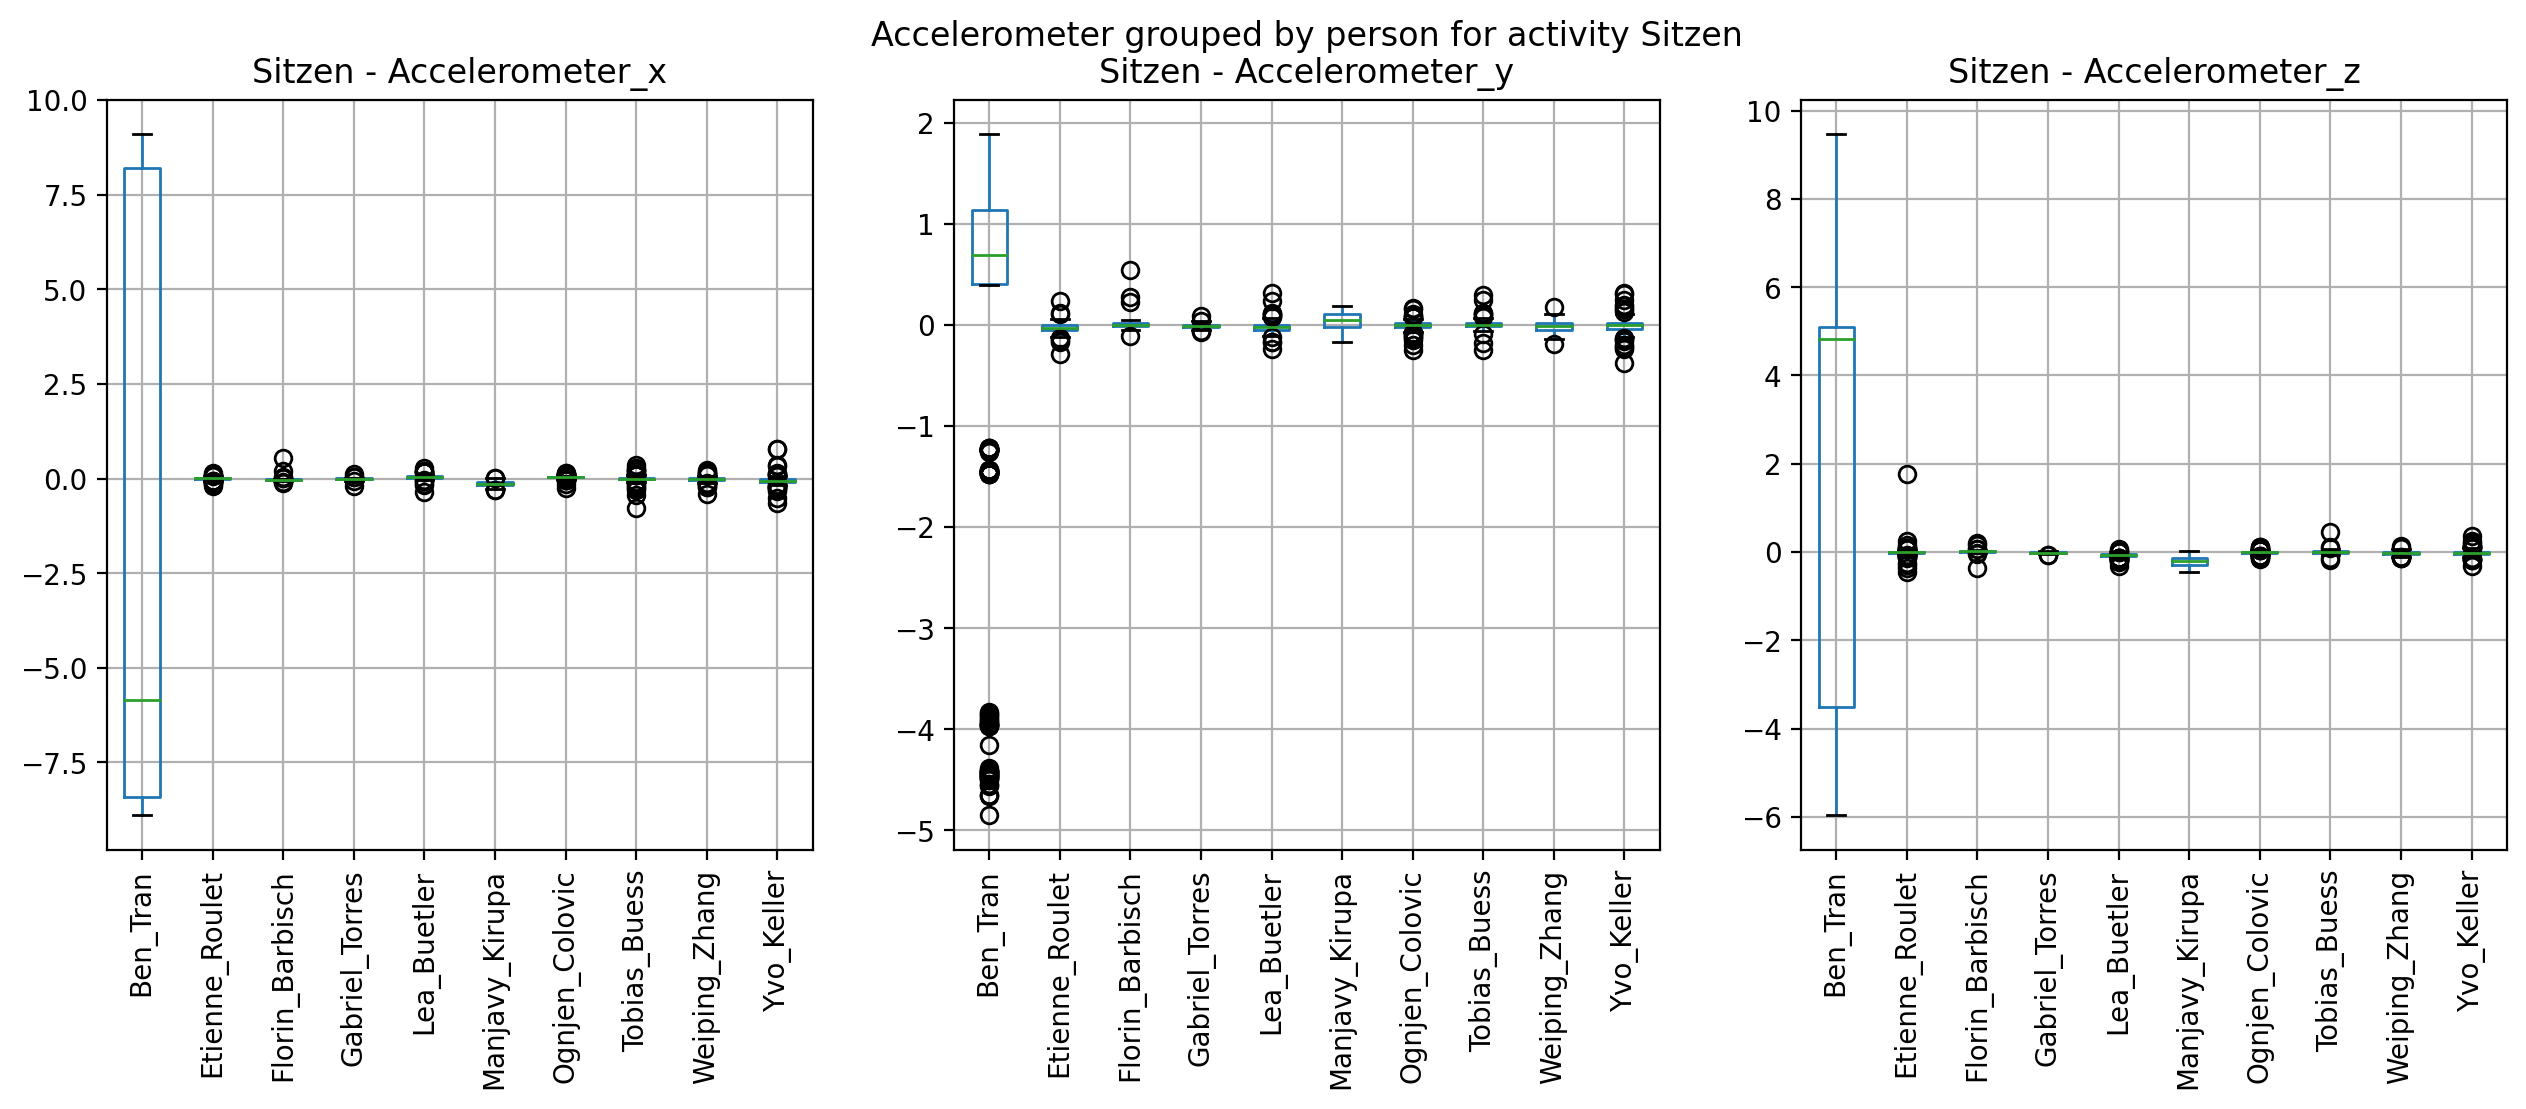

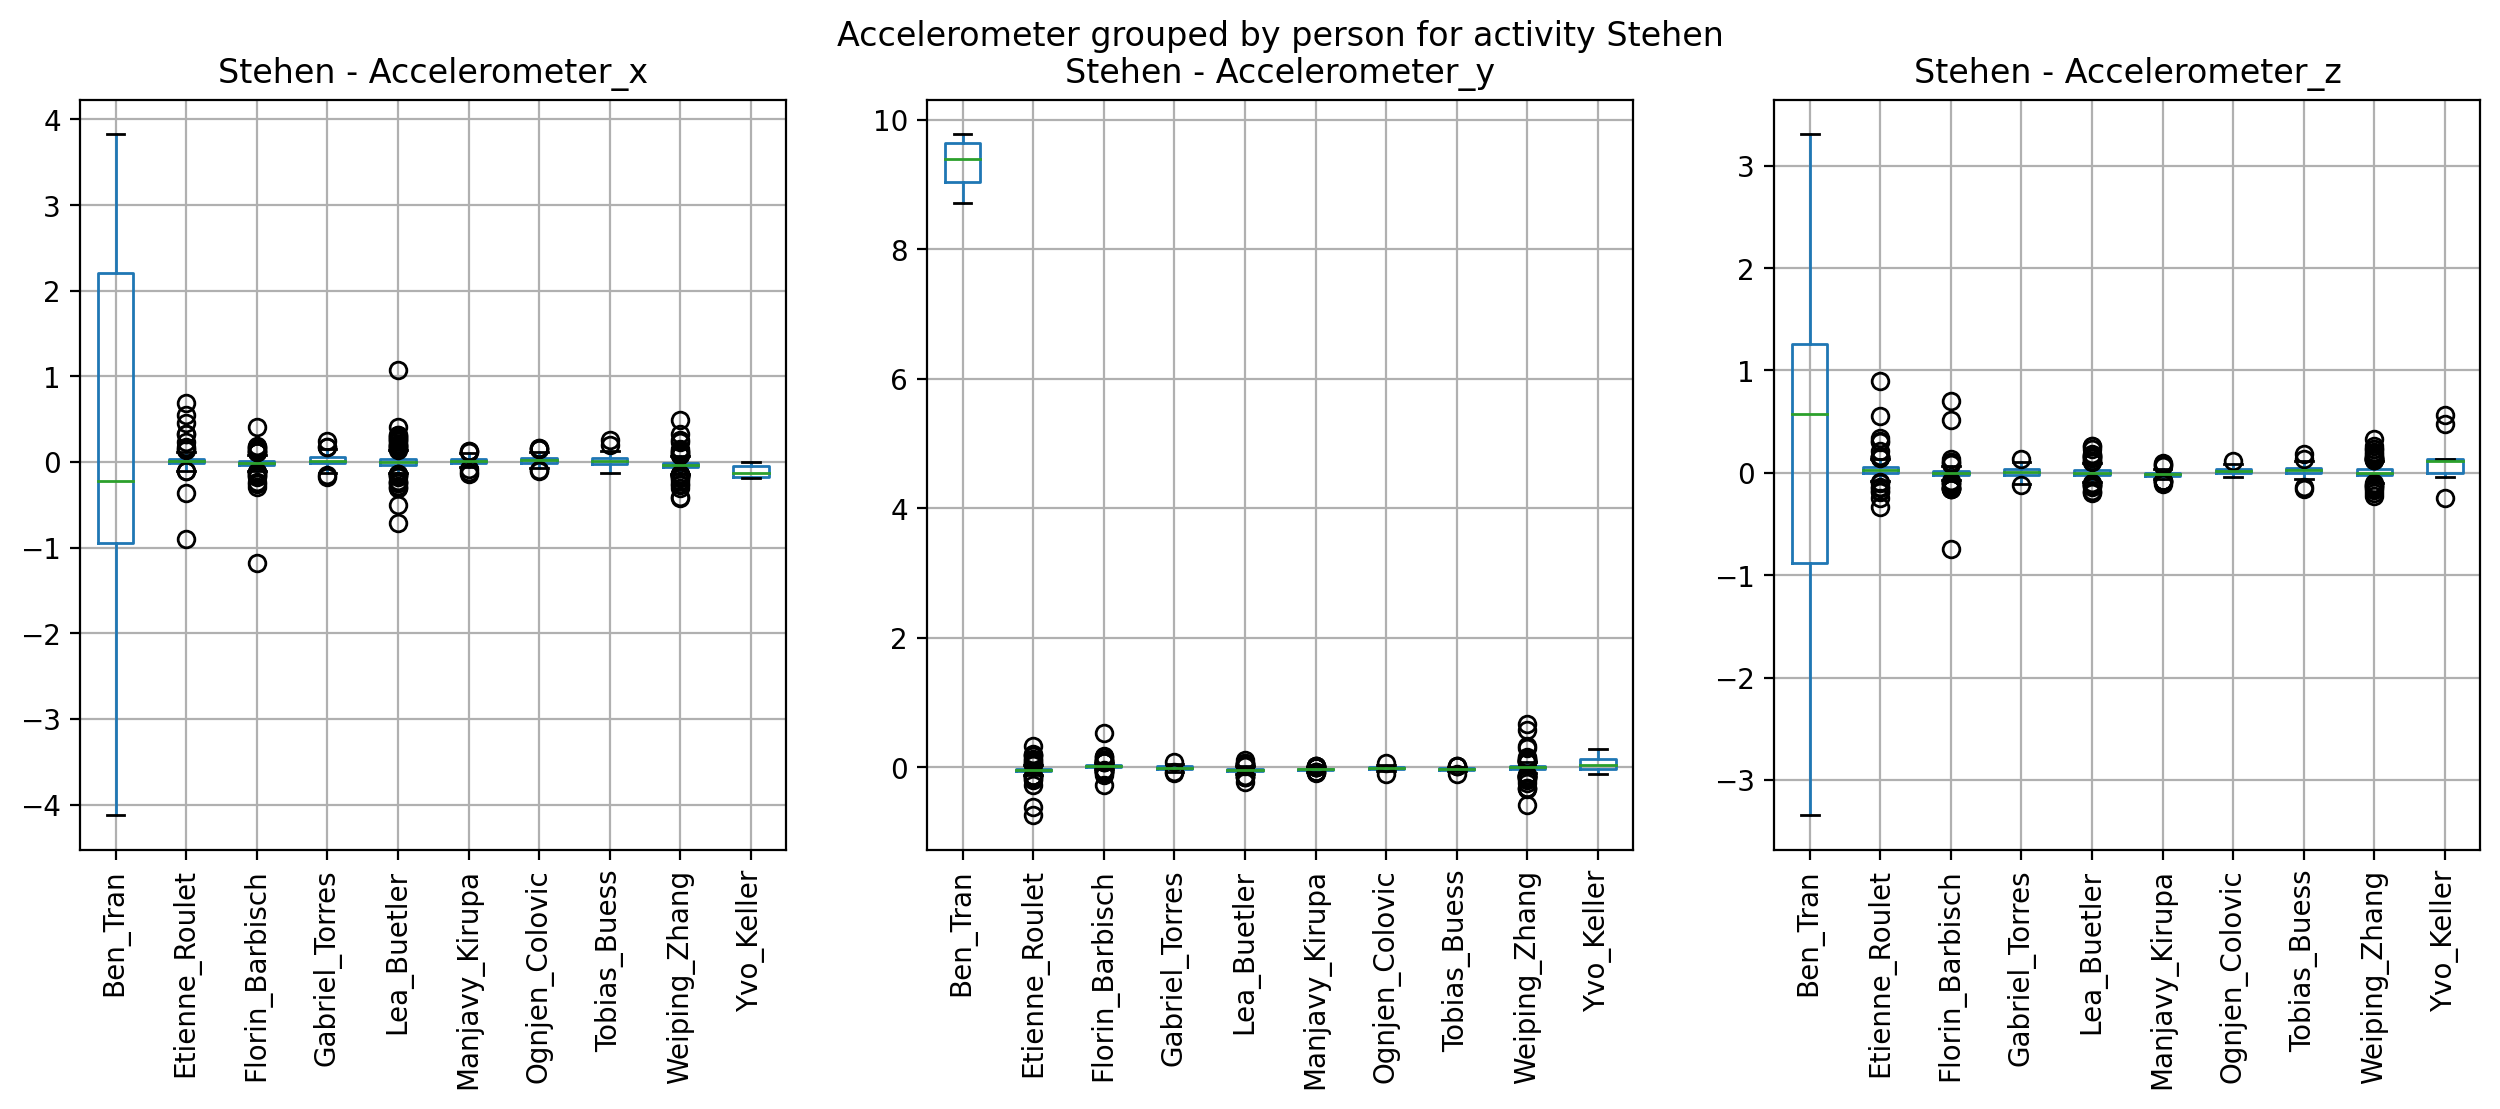

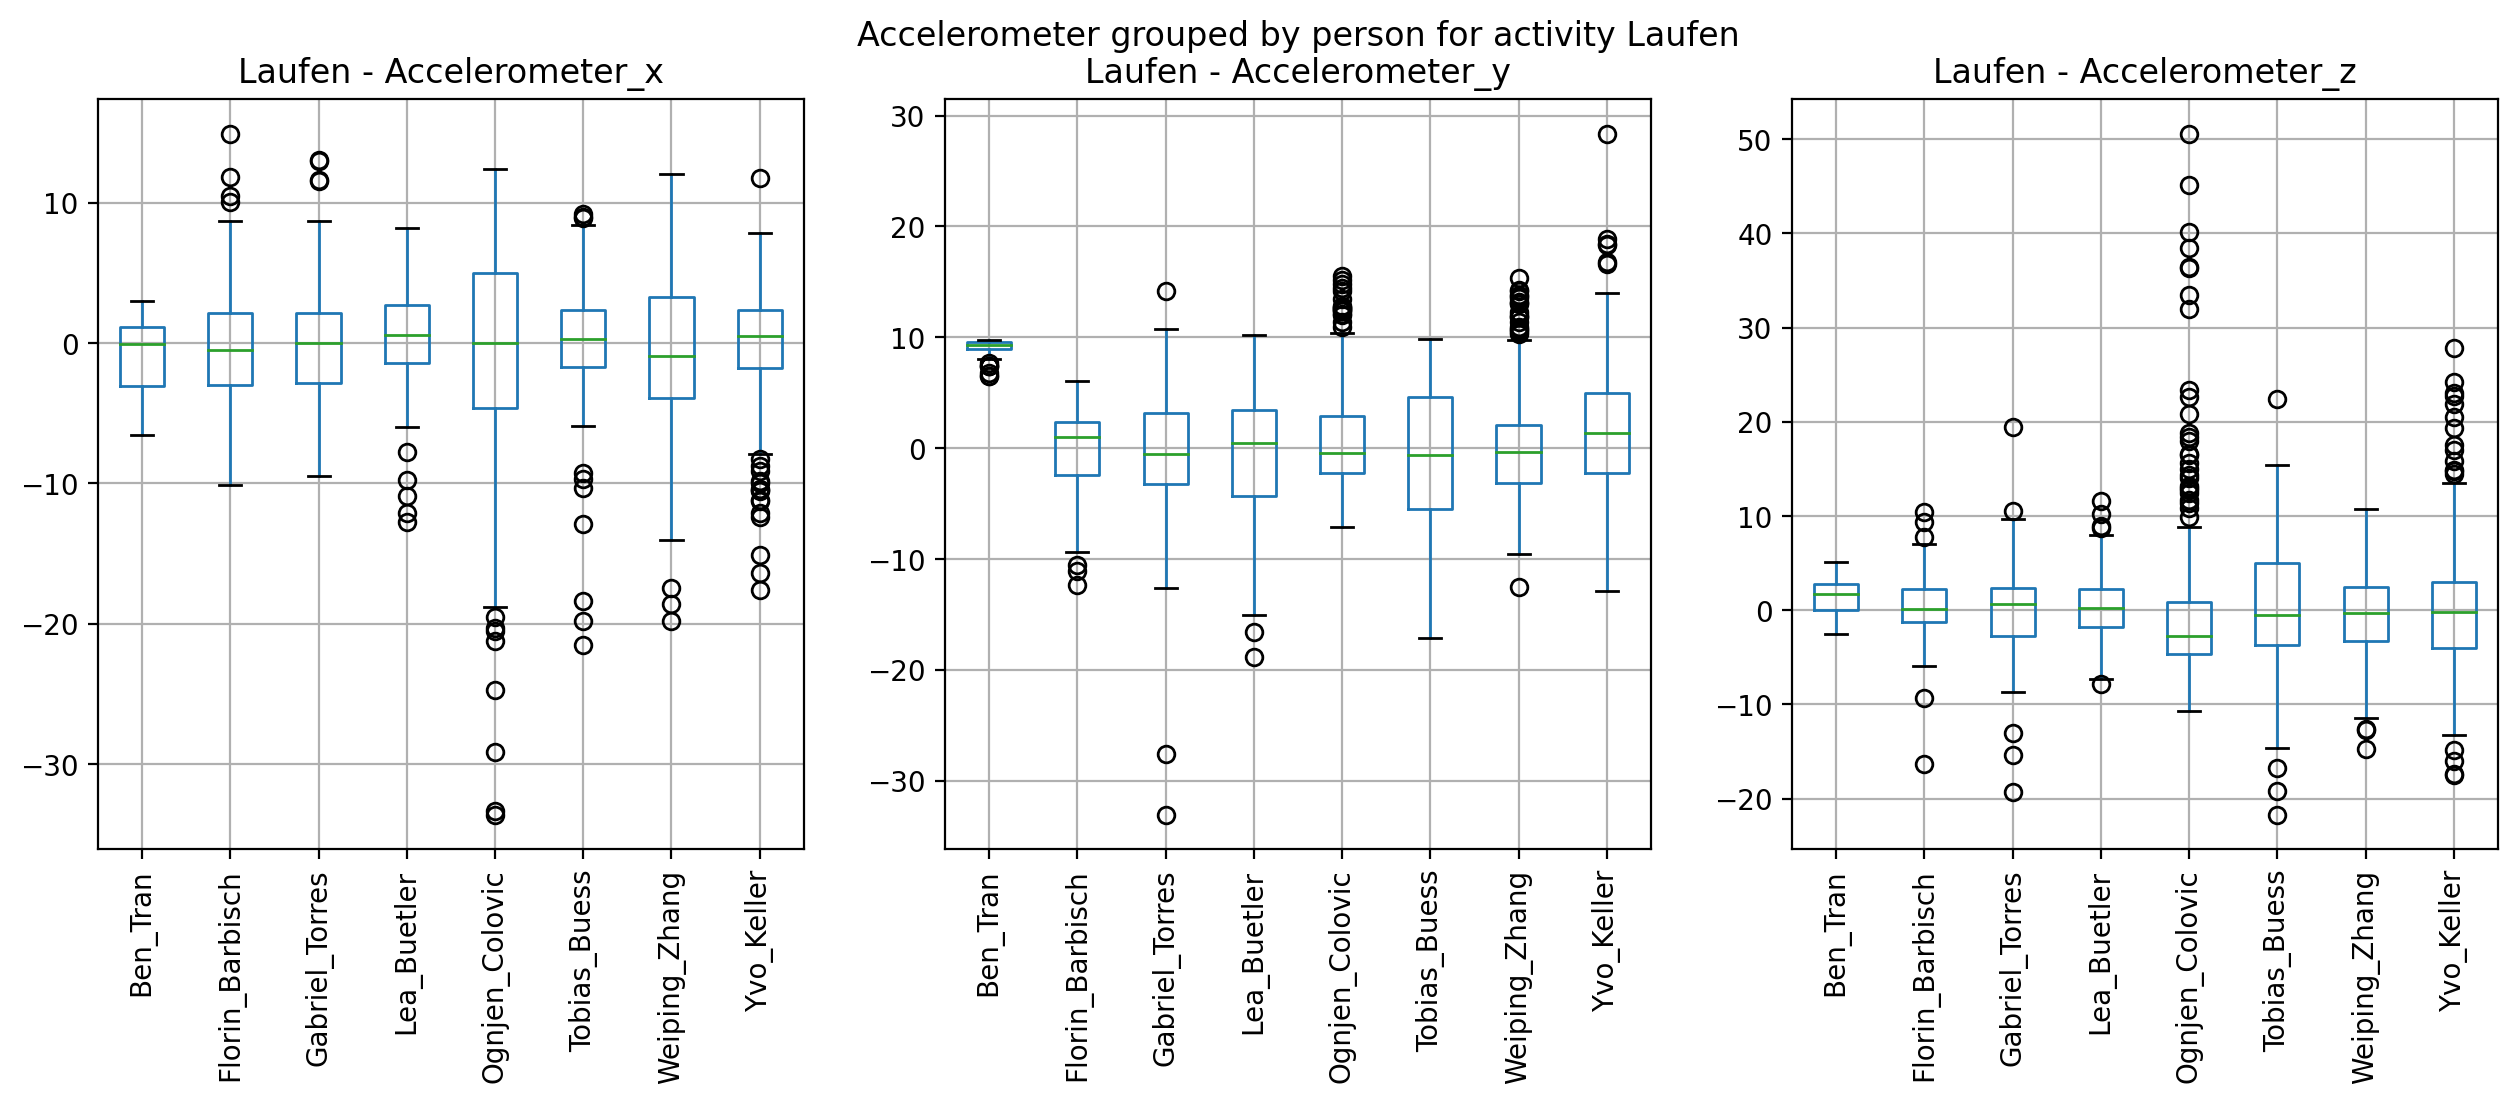

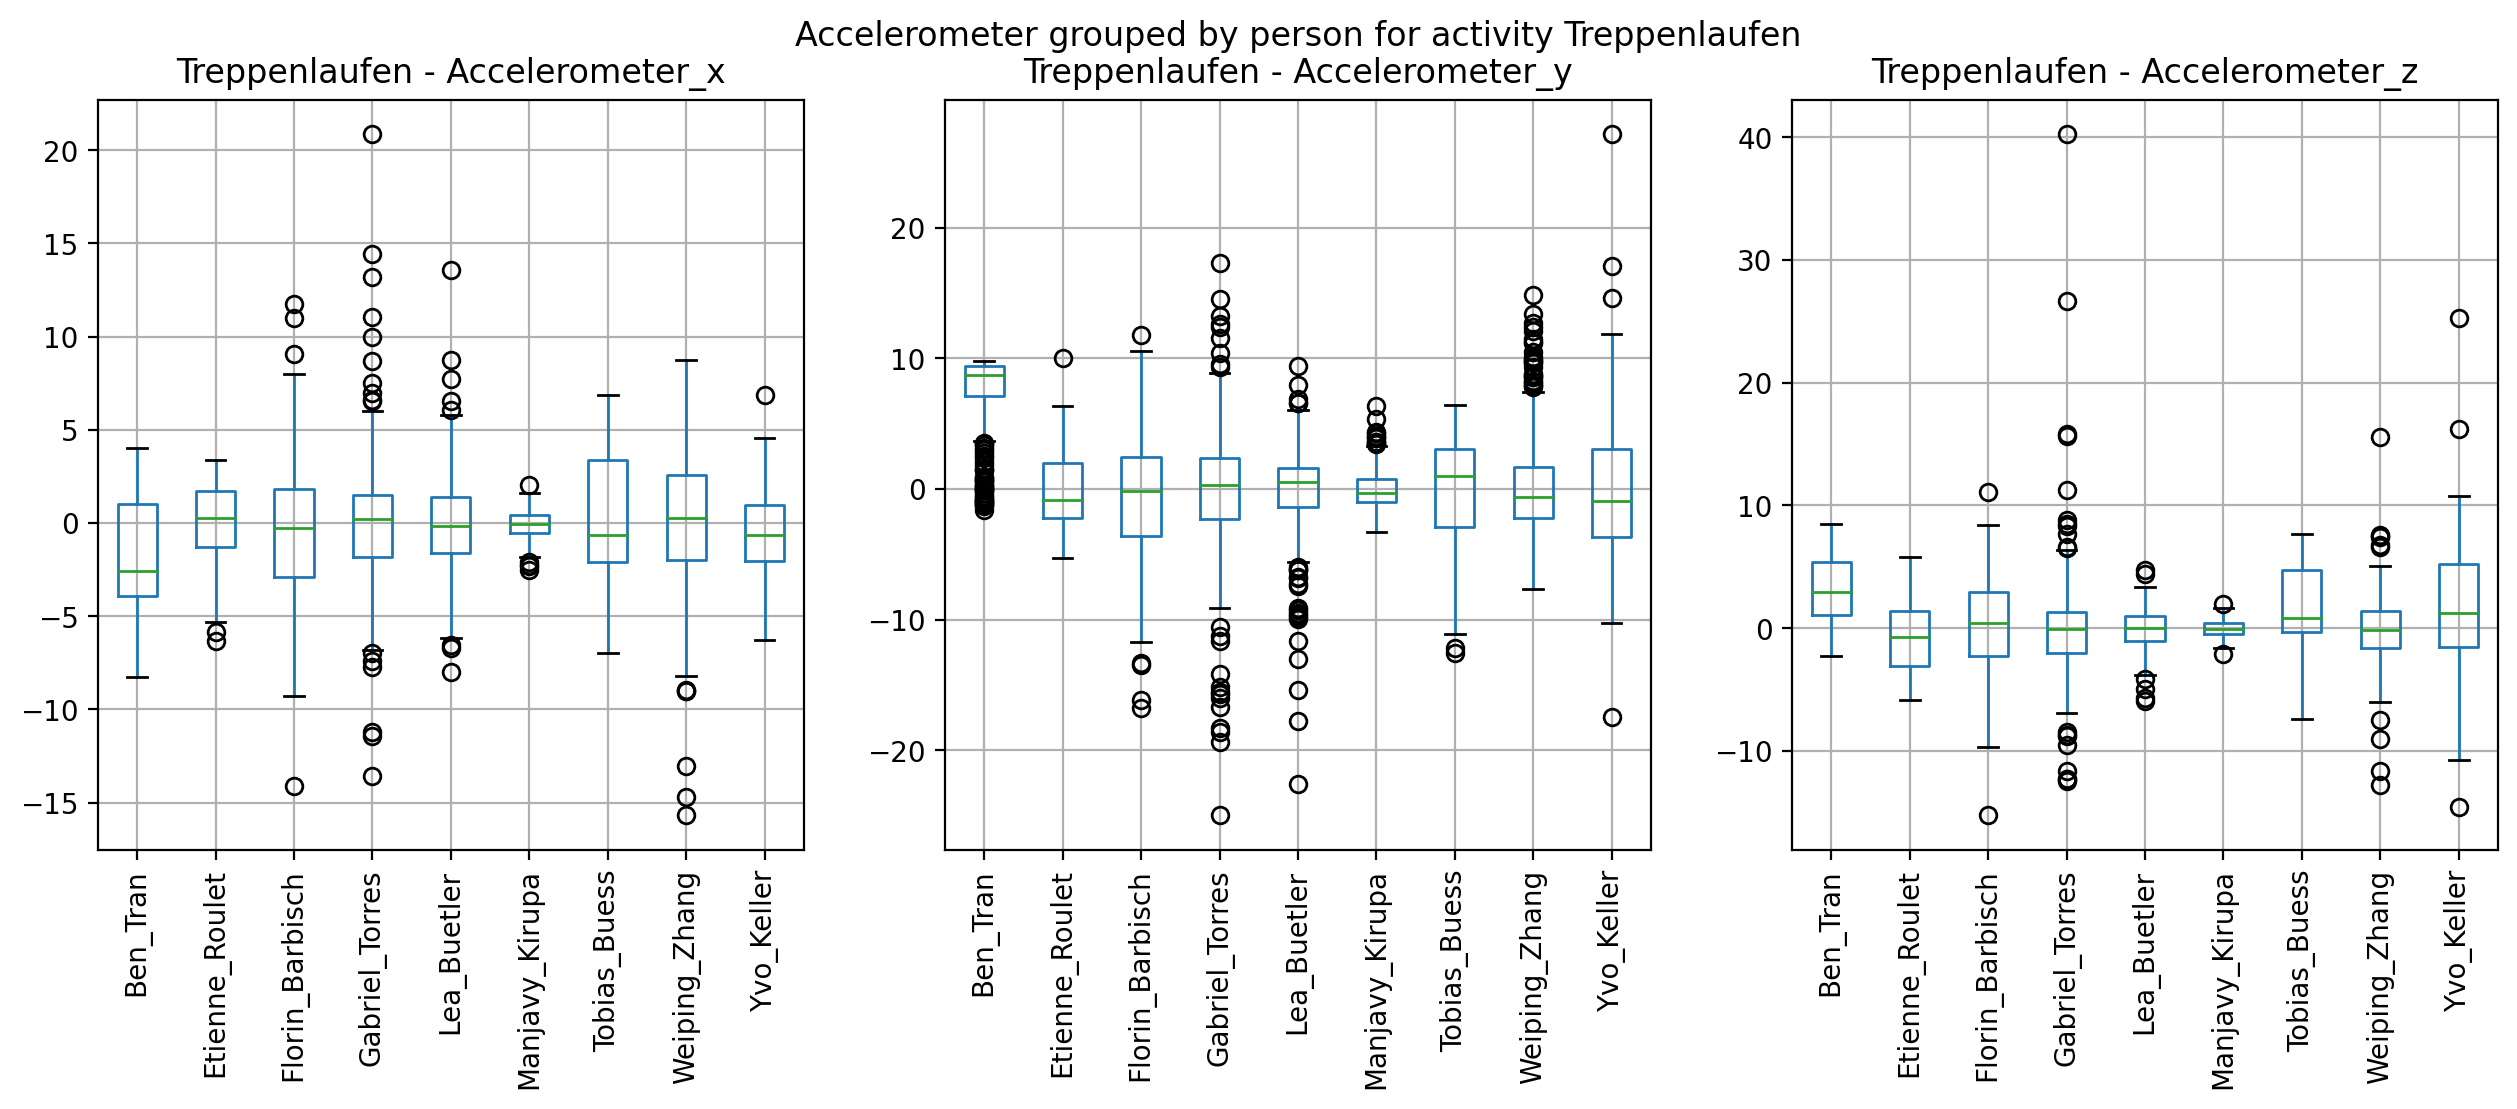

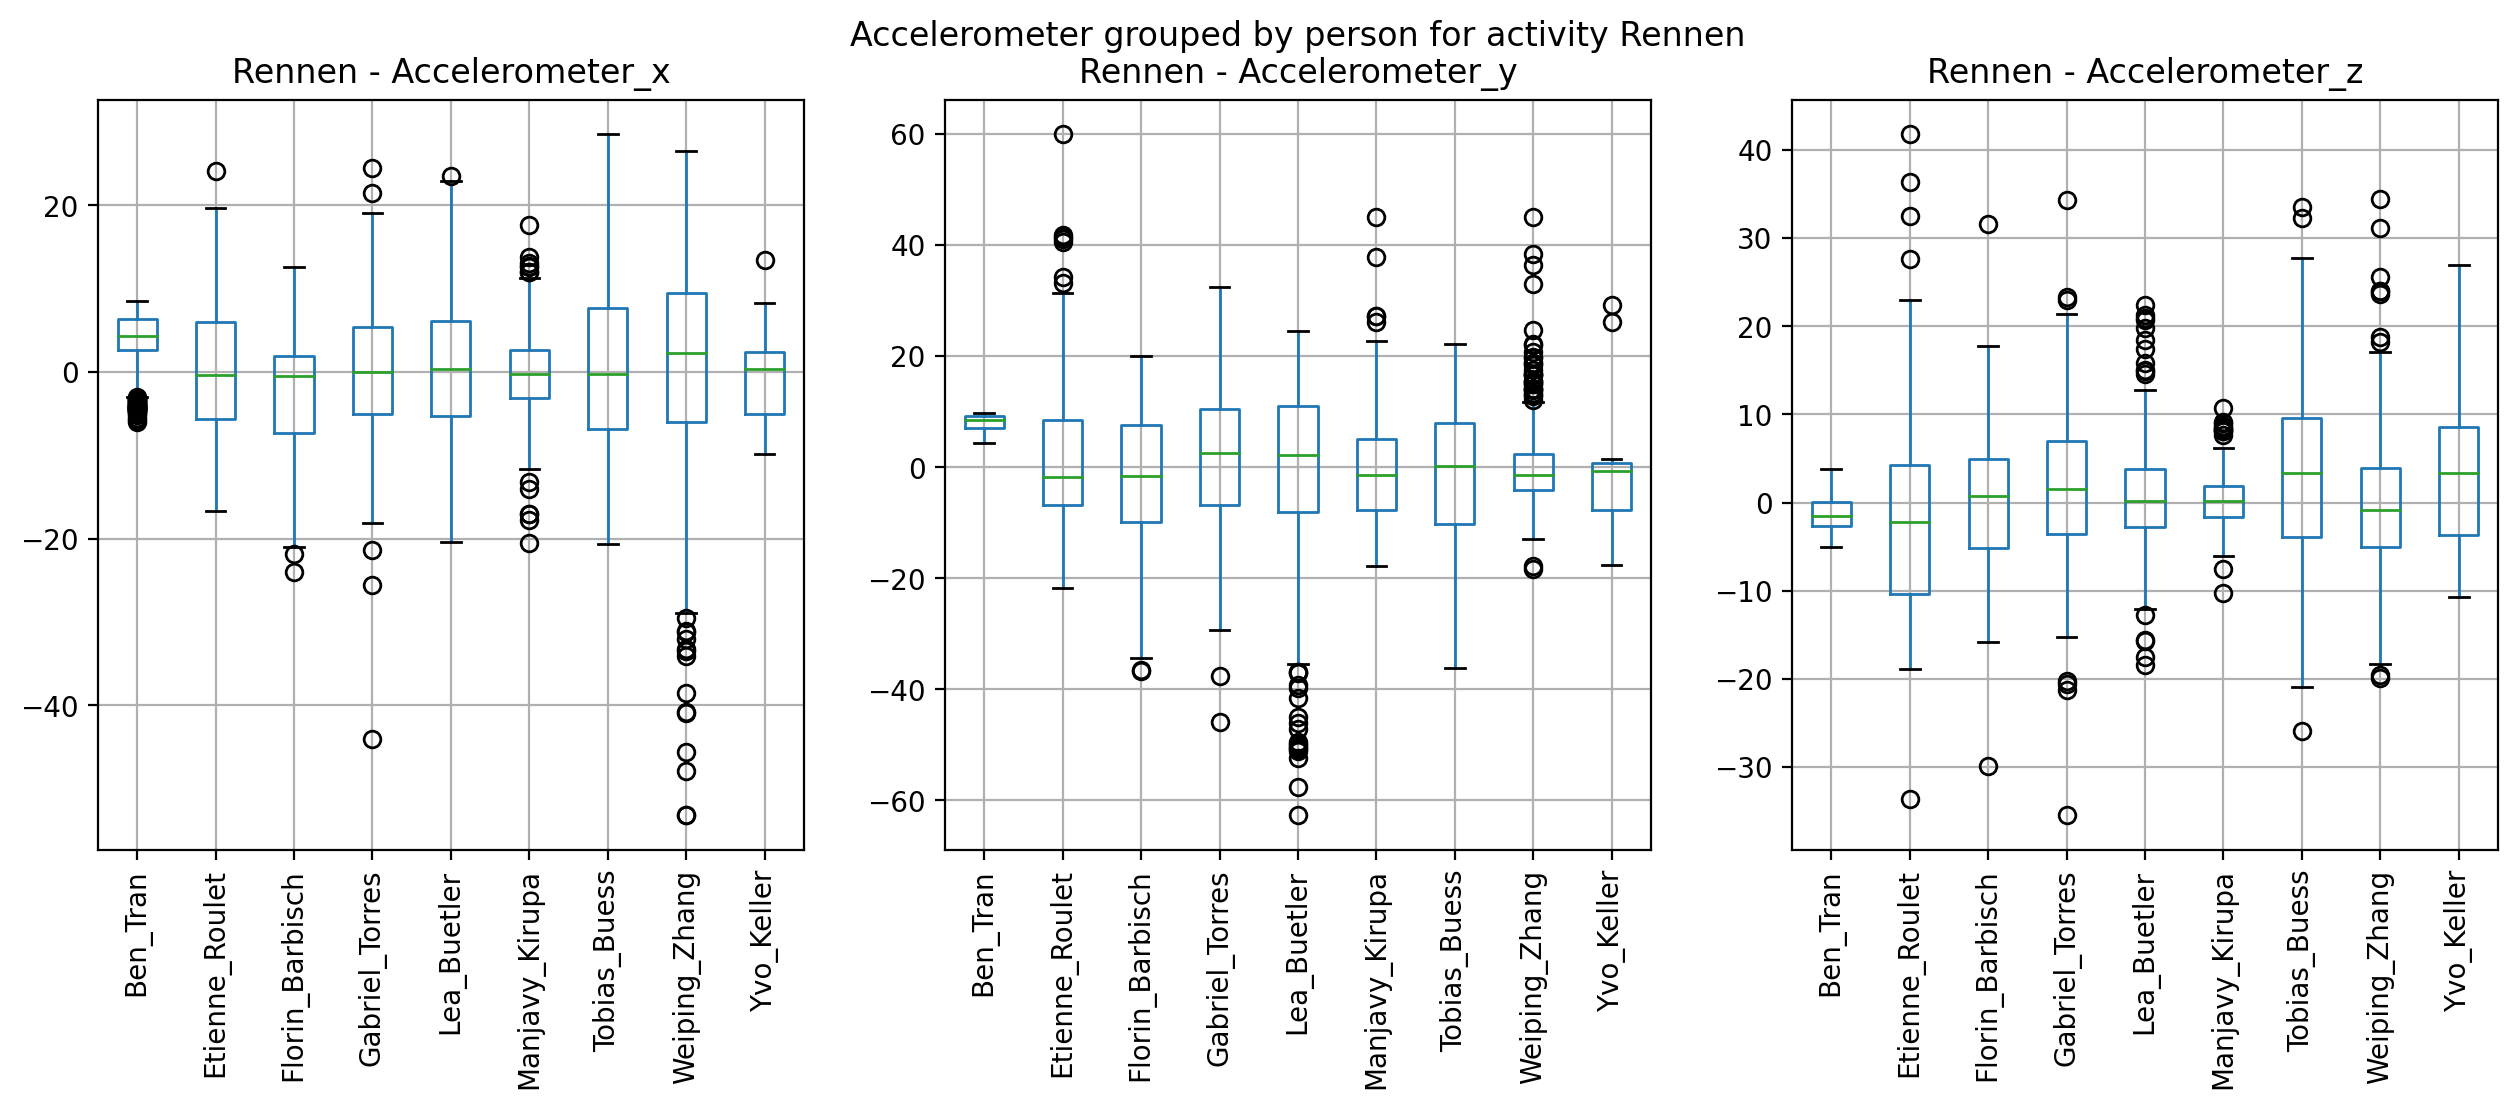

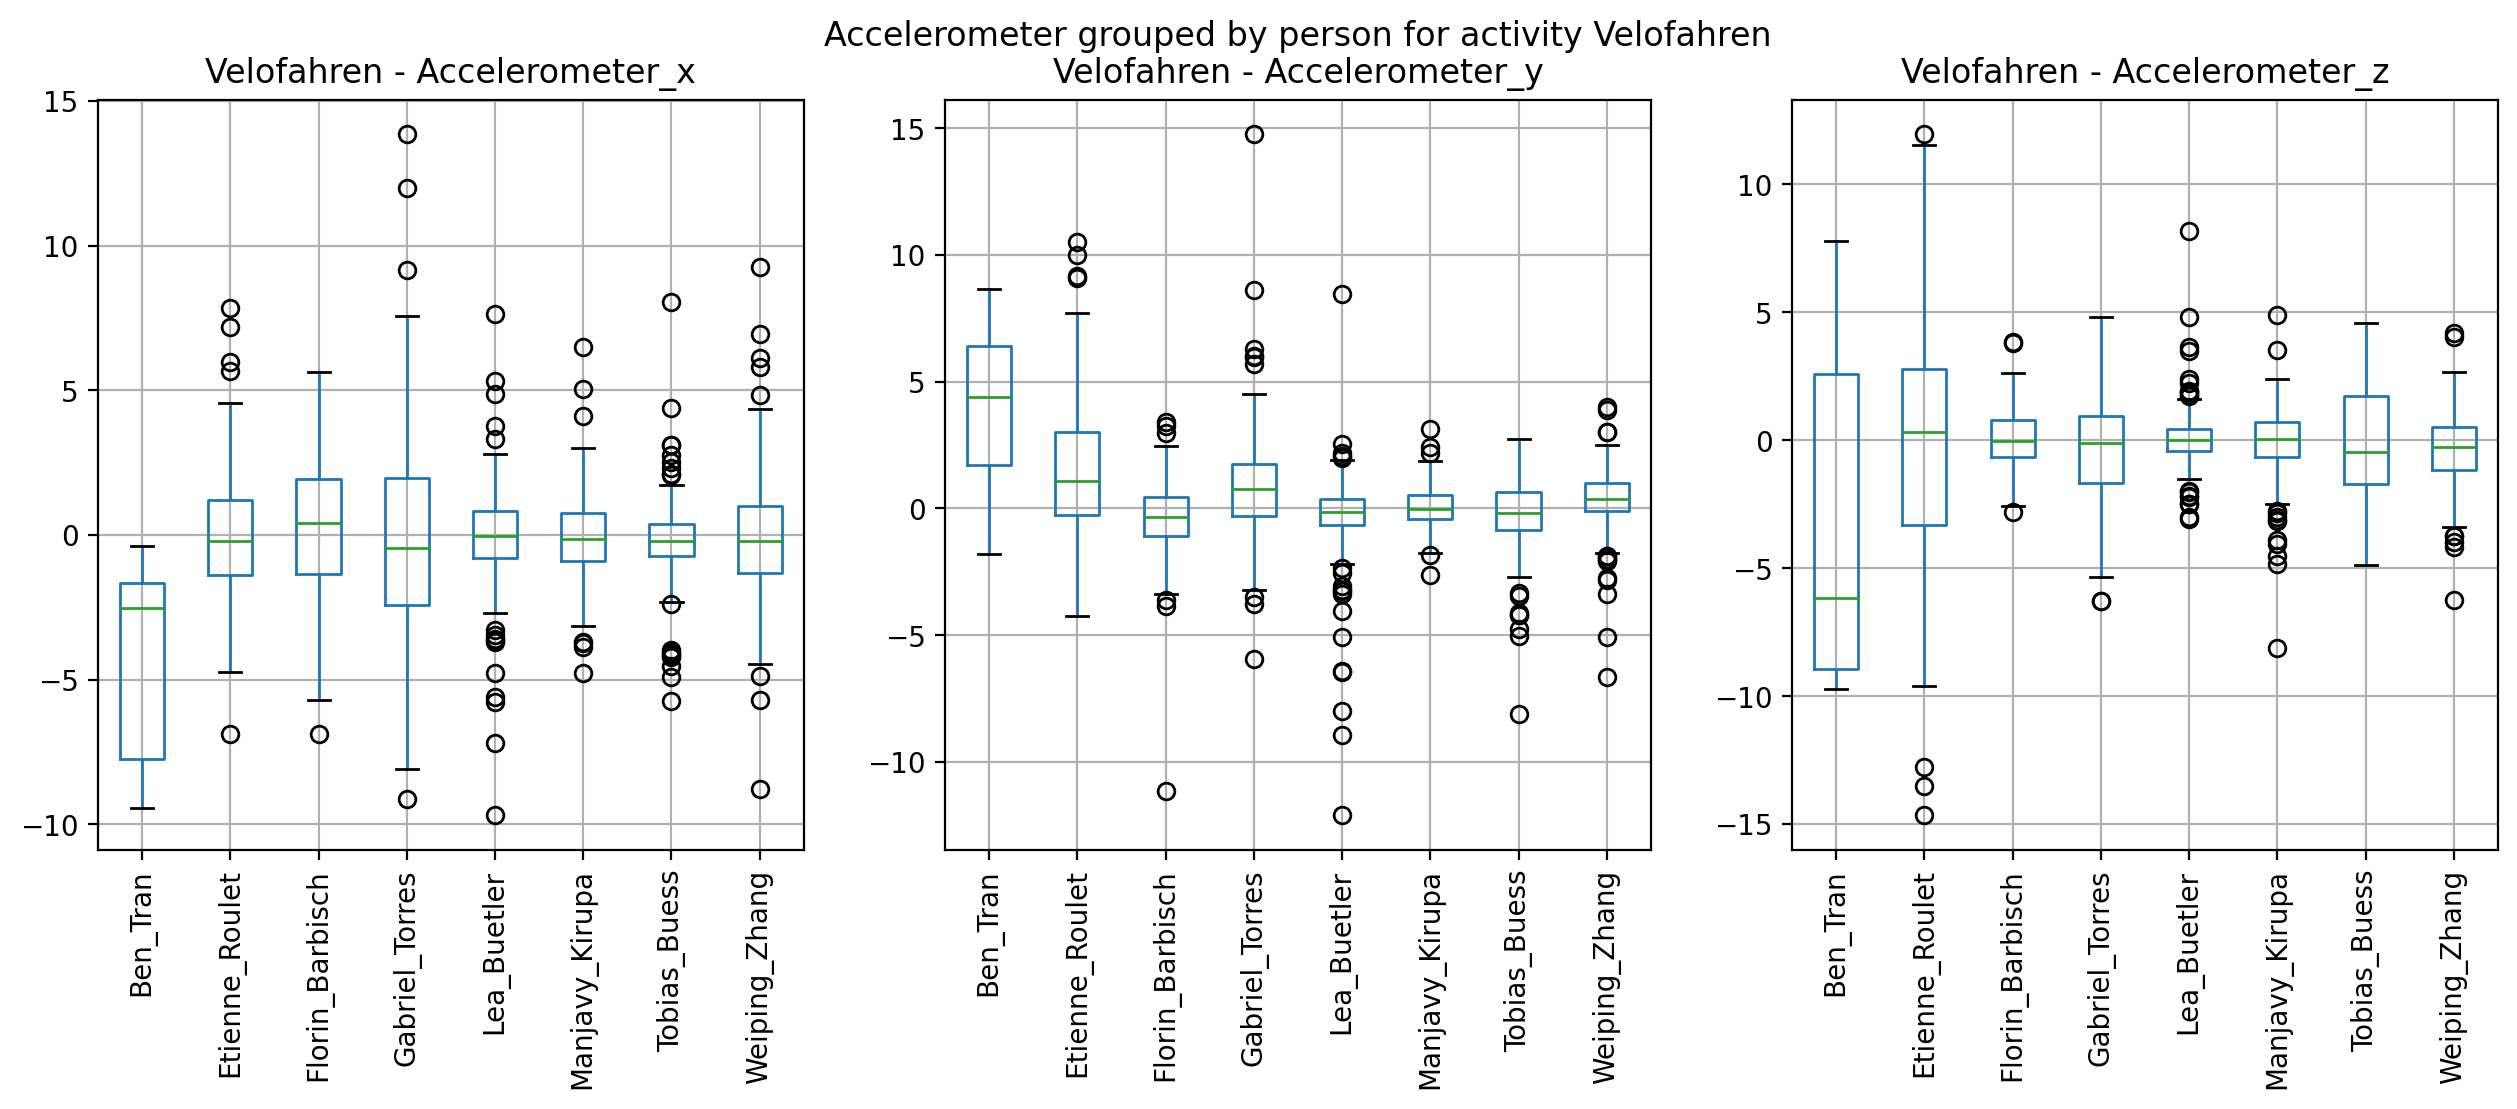

In [ ]:
def plot_boxplot(df_input):
    activity = df_input['activity'].unique()[0]
    # df_sample_accelerometer.boxplot(by=['person'], rot=90)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, axis in enumerate(['Accelerometer_x', 'Accelerometer_y', 'Accelerometer_z']):
        df_input.boxplot(by=['person'], rot=90, ax=axs[i], column=axis)
        axs[i].set_title(f'{activity} - {axis}')
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')

    plt.suptitle(f'Accelerometer grouped by person for activity {activity}')
    plt.show()

activities_call(activities, df_sample_accelerometer, plot_boxplot)

**Notes**

- Looking at these measurements grouped by person, we can see that Ben's phone is a clear outlier, especially visible in the Stehen and Sitzen acitivty. We will need to decide whether to include this dataset for our model training.

## Correlations between Accelerometer x, y and z

### x, y, z correlation by activity

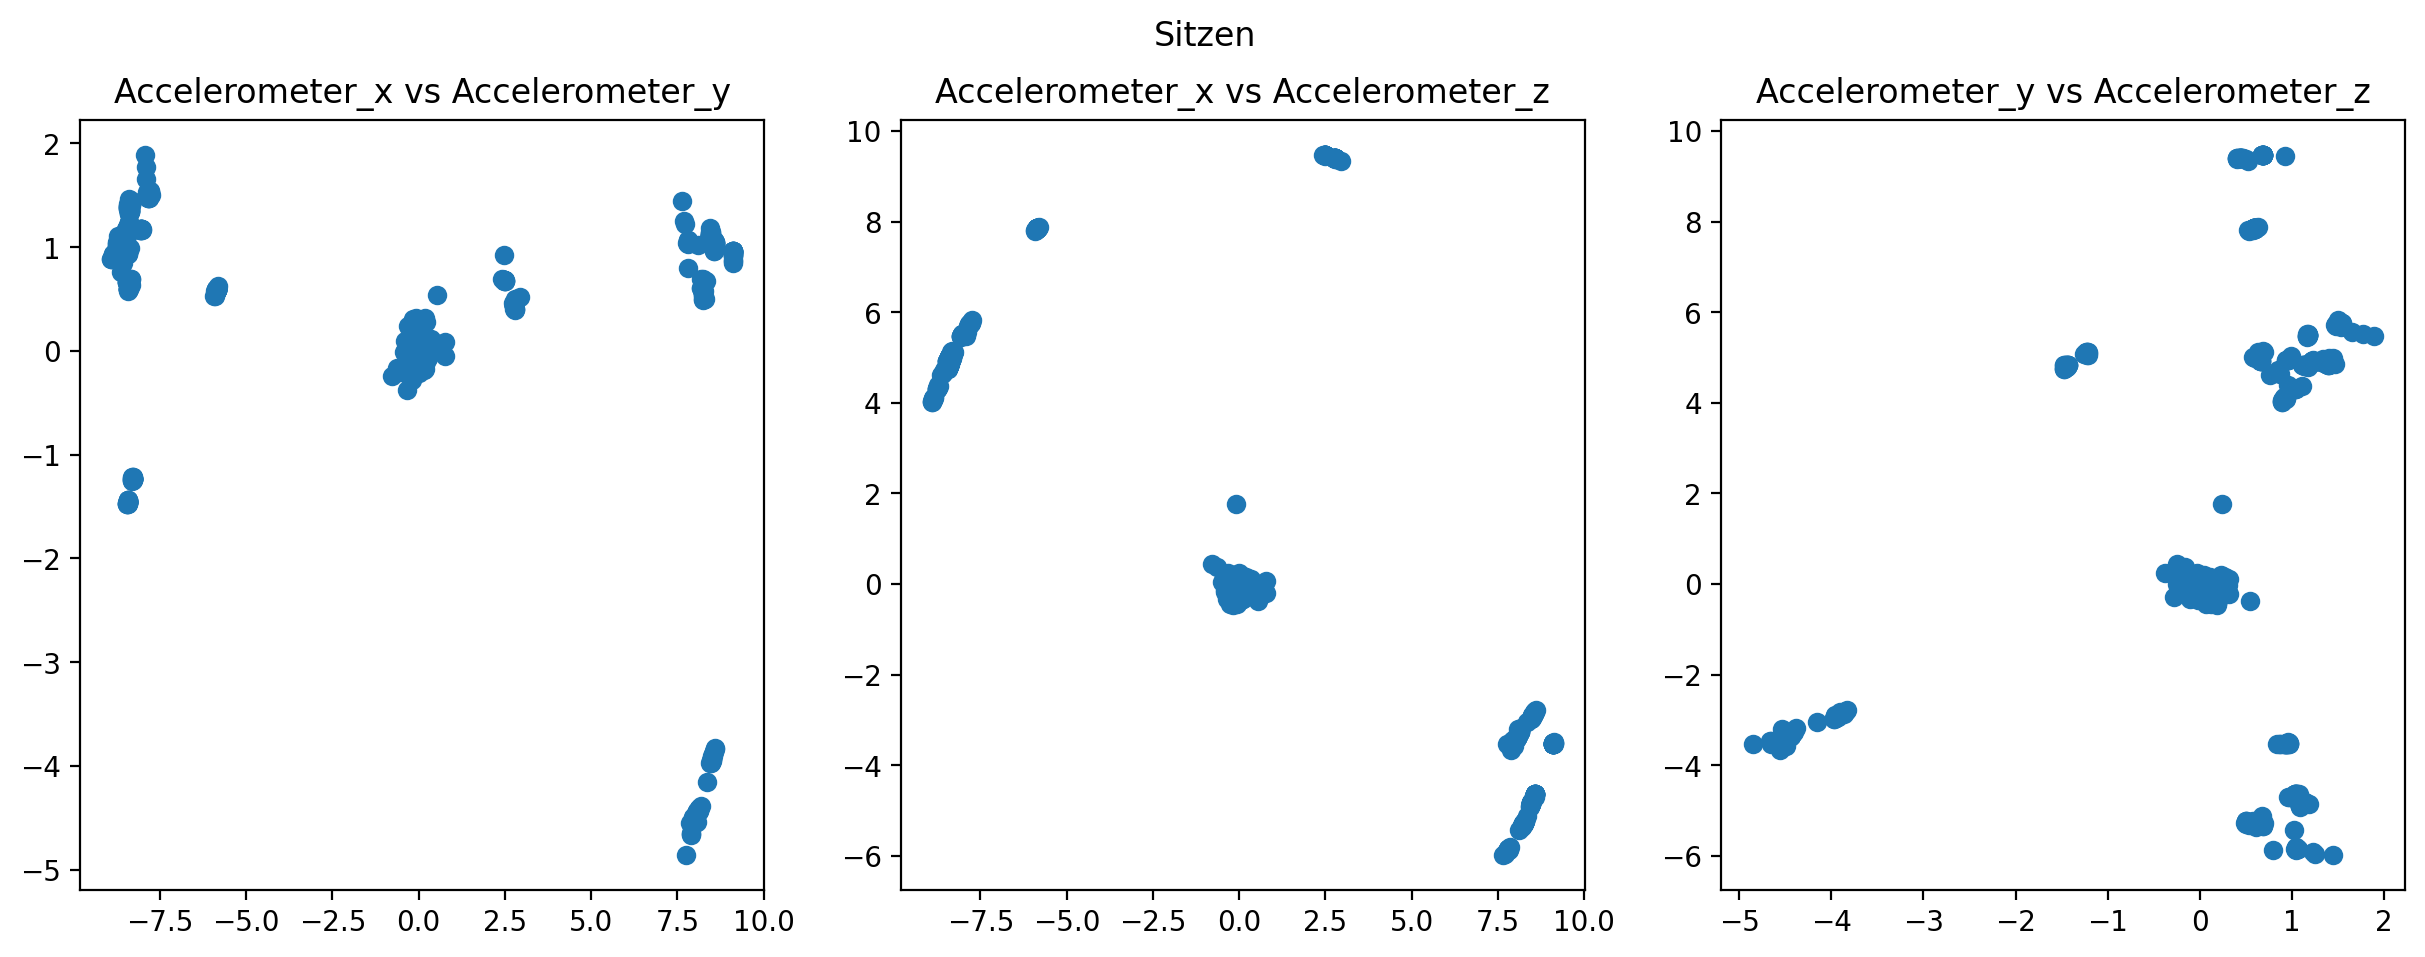

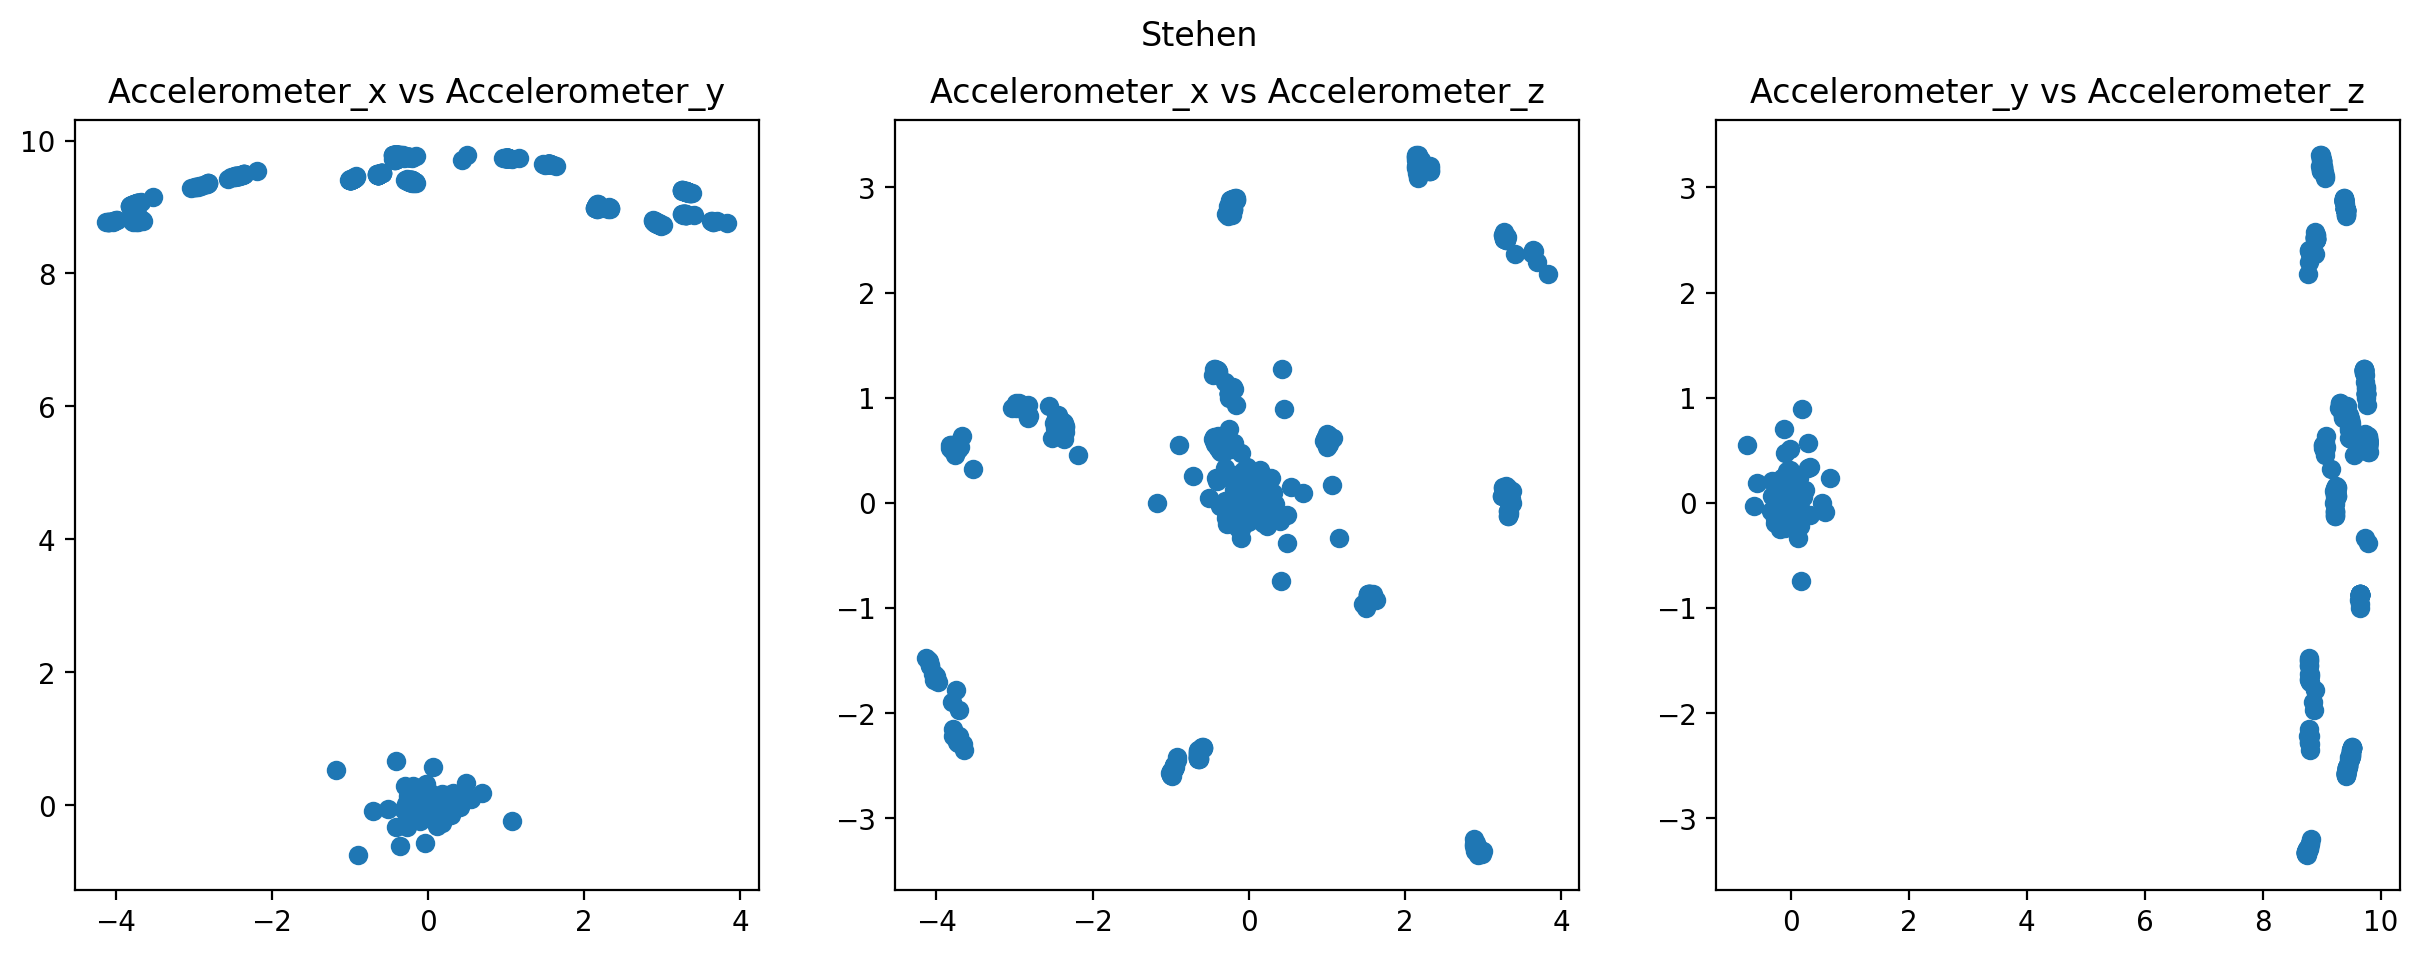

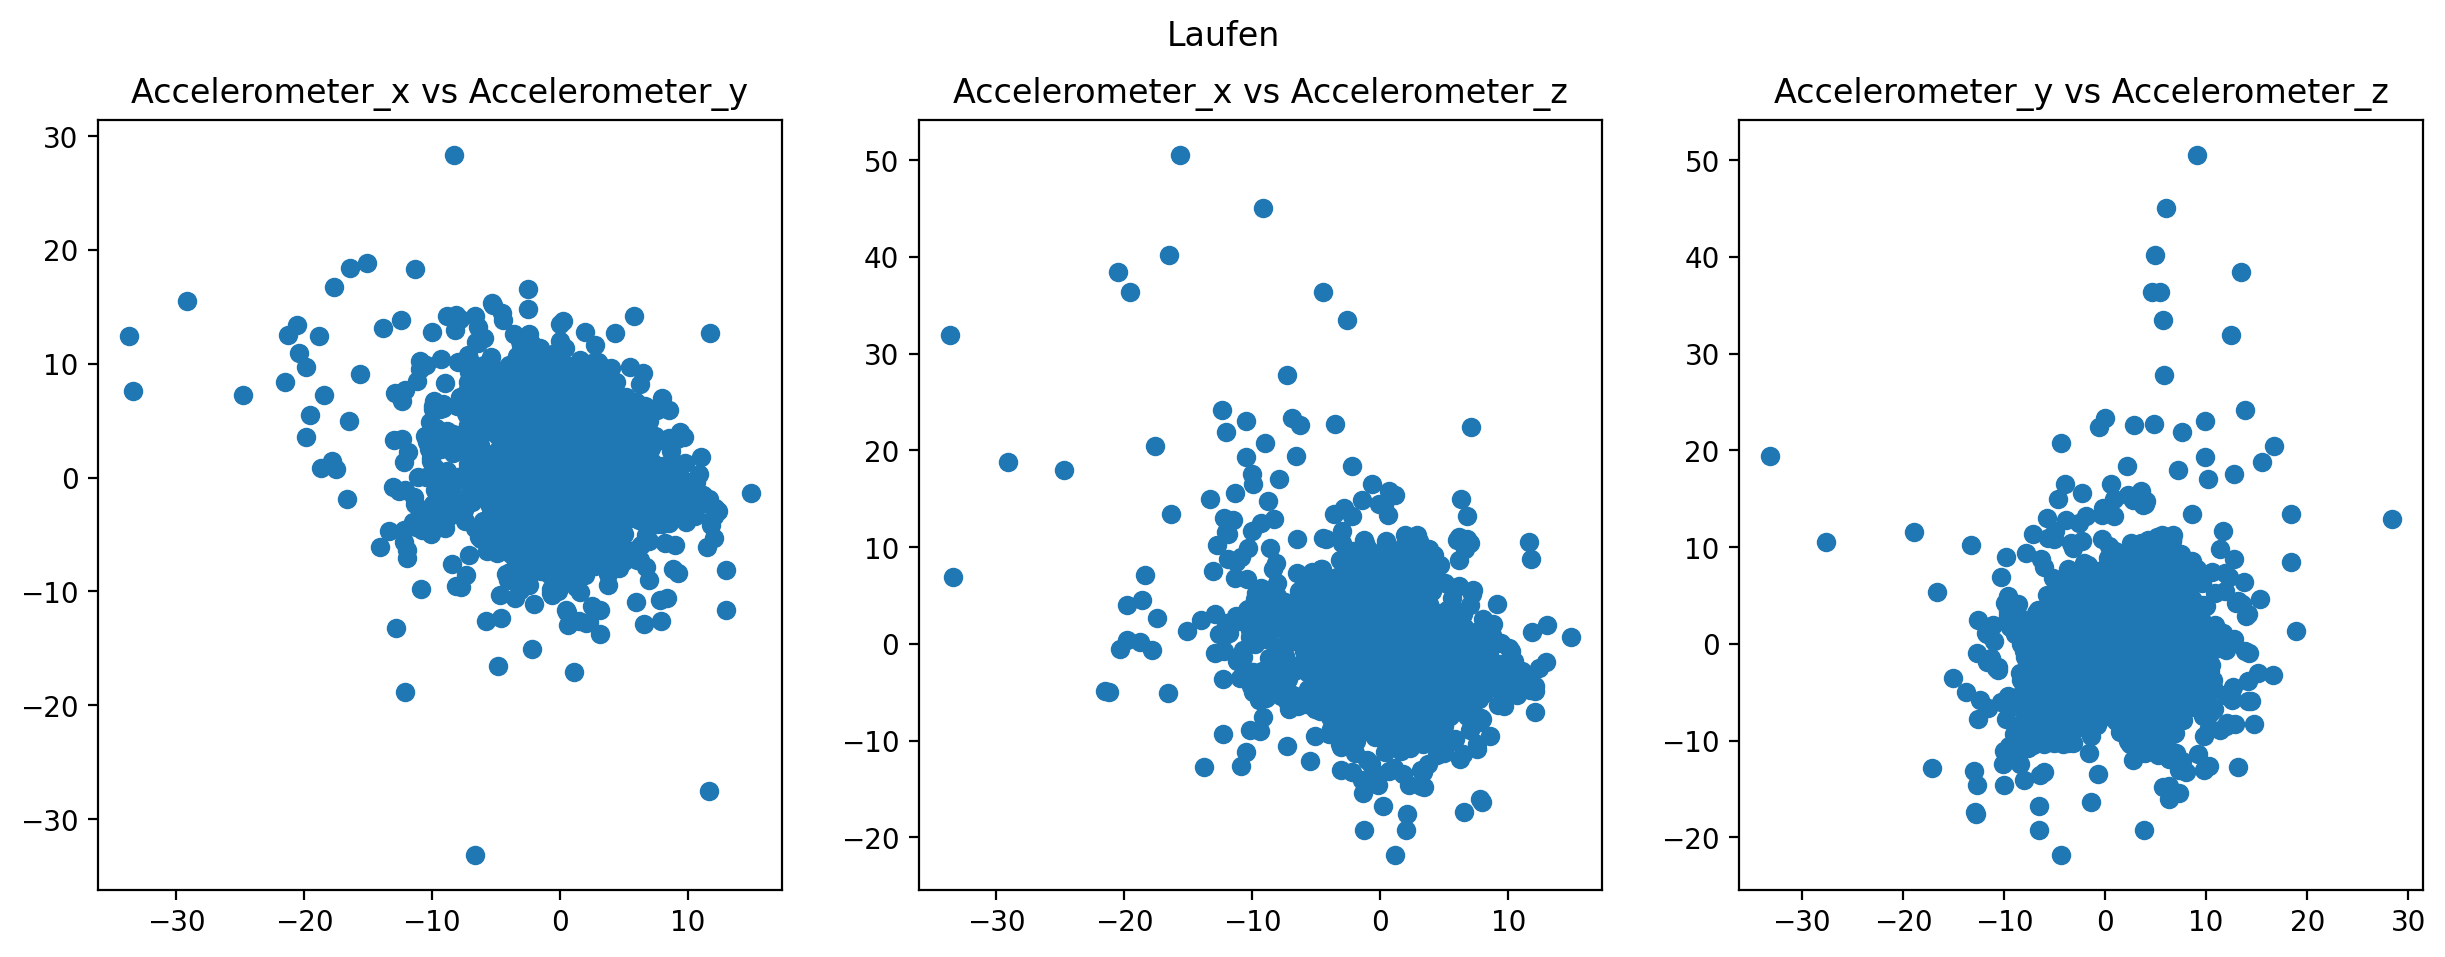

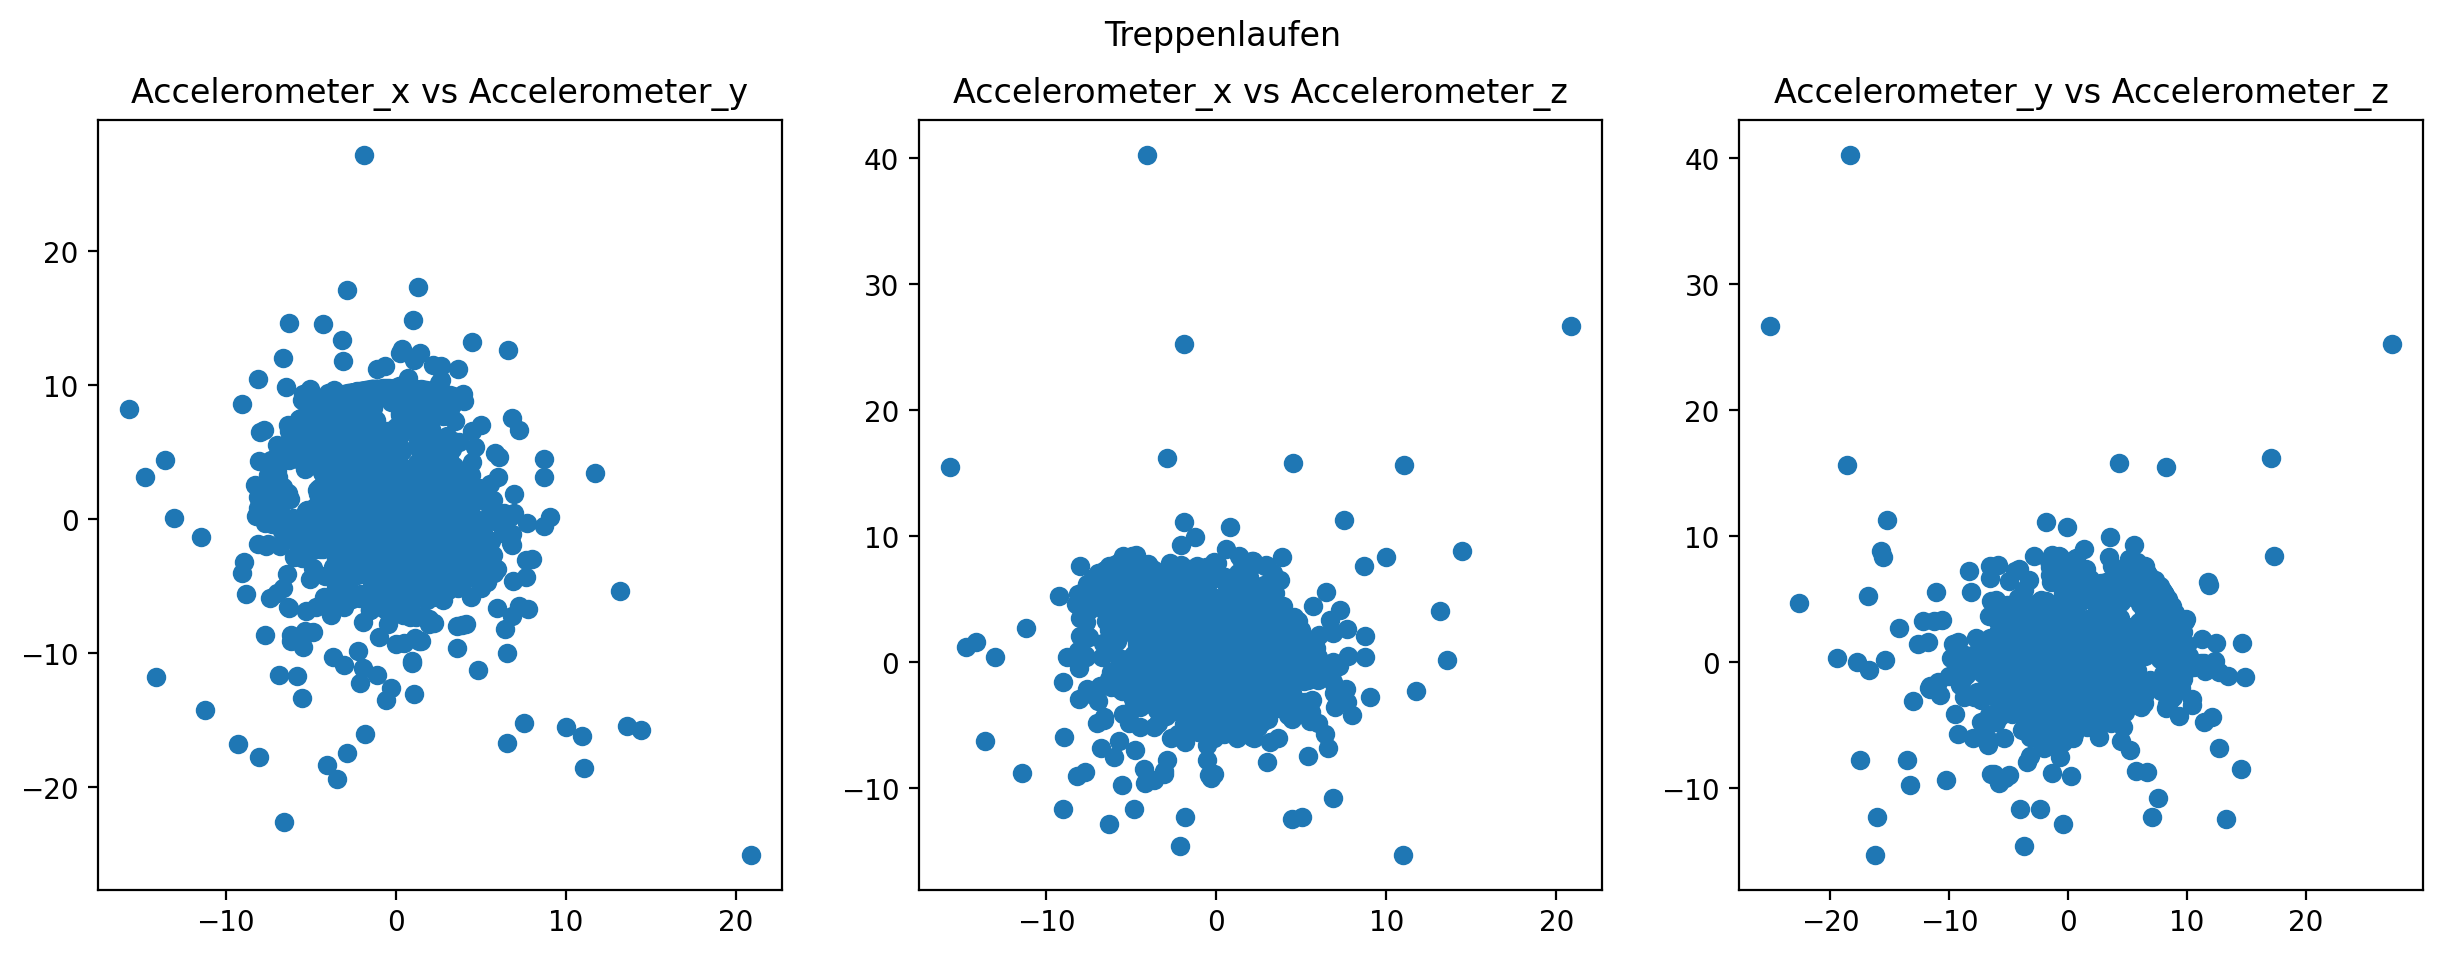

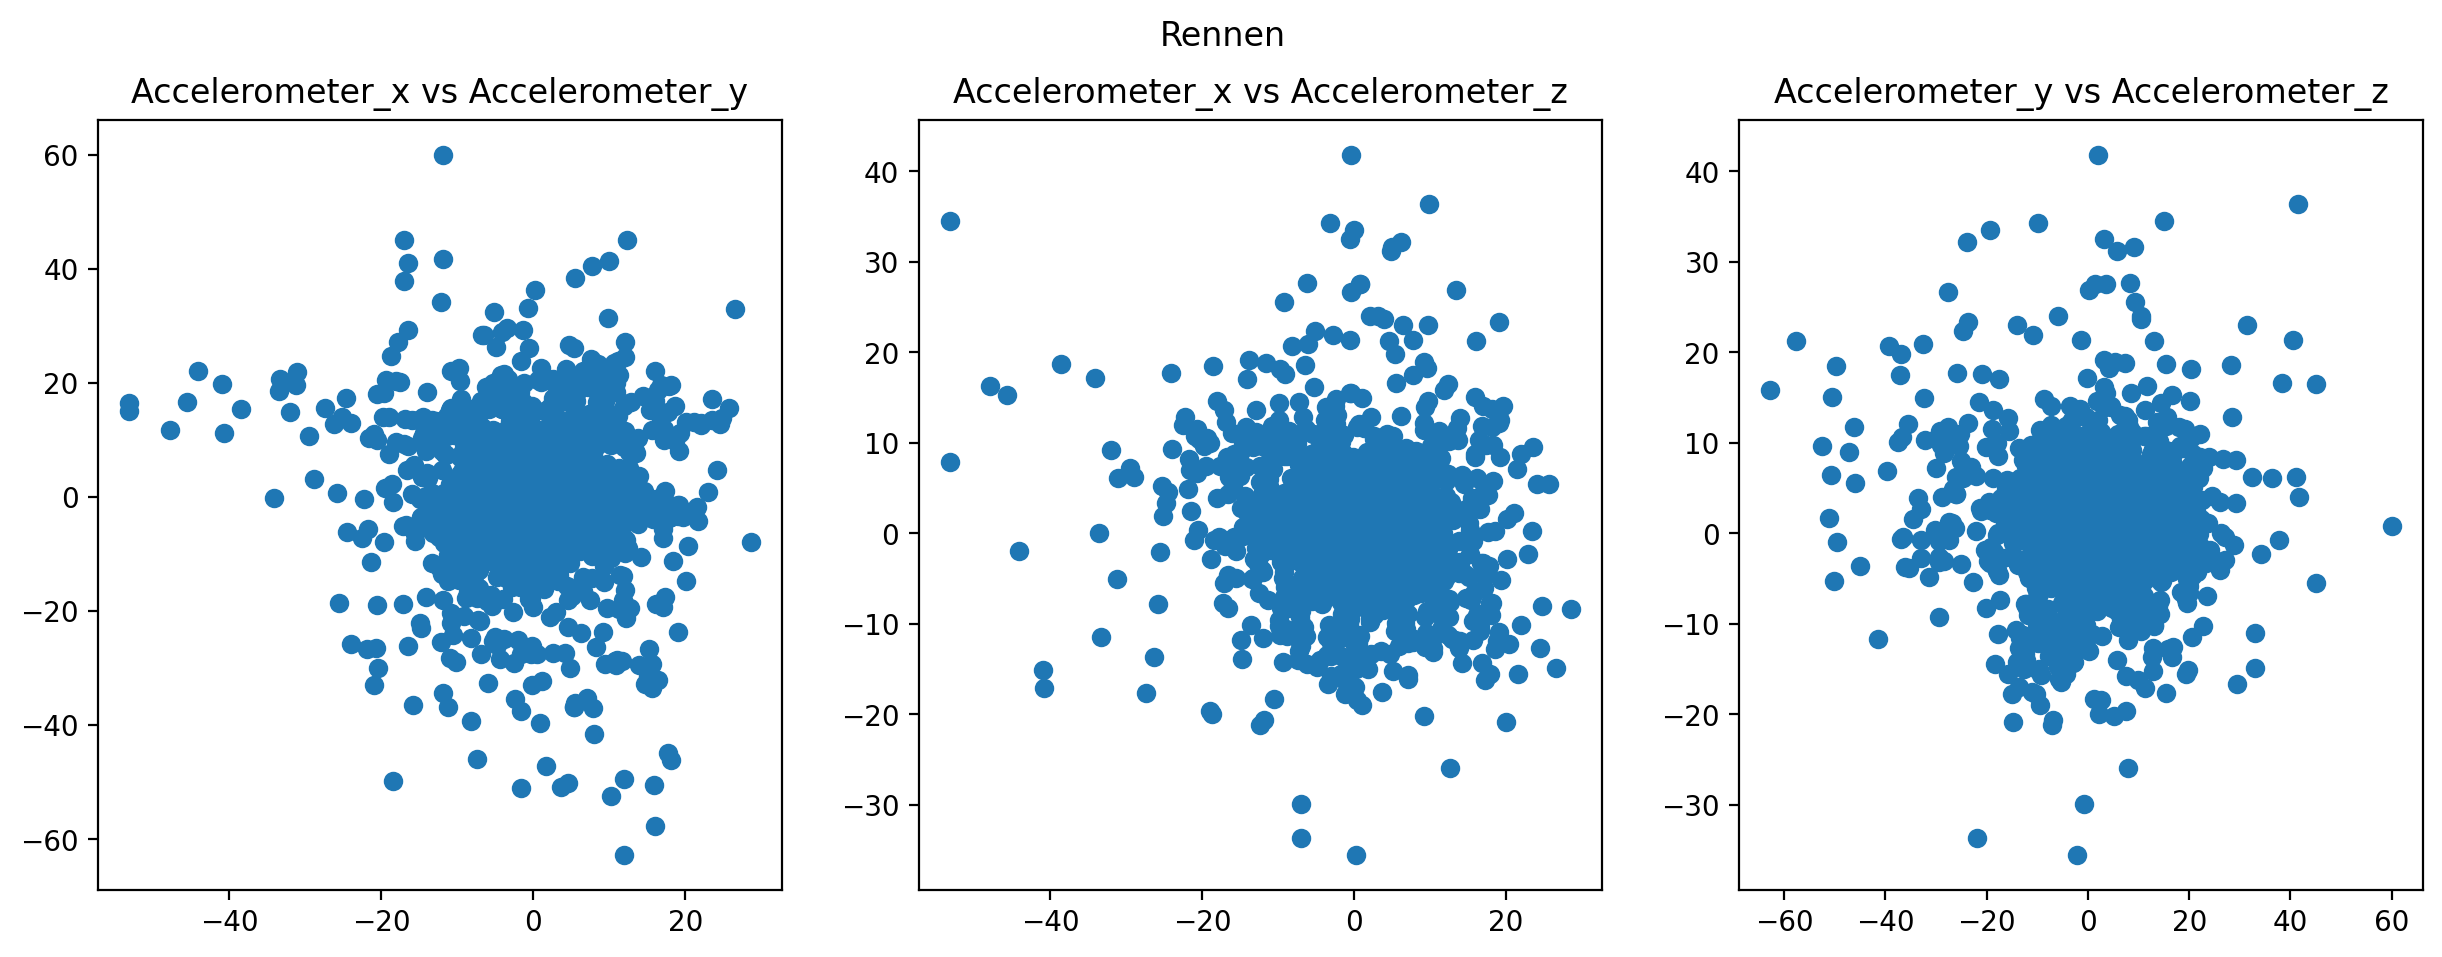

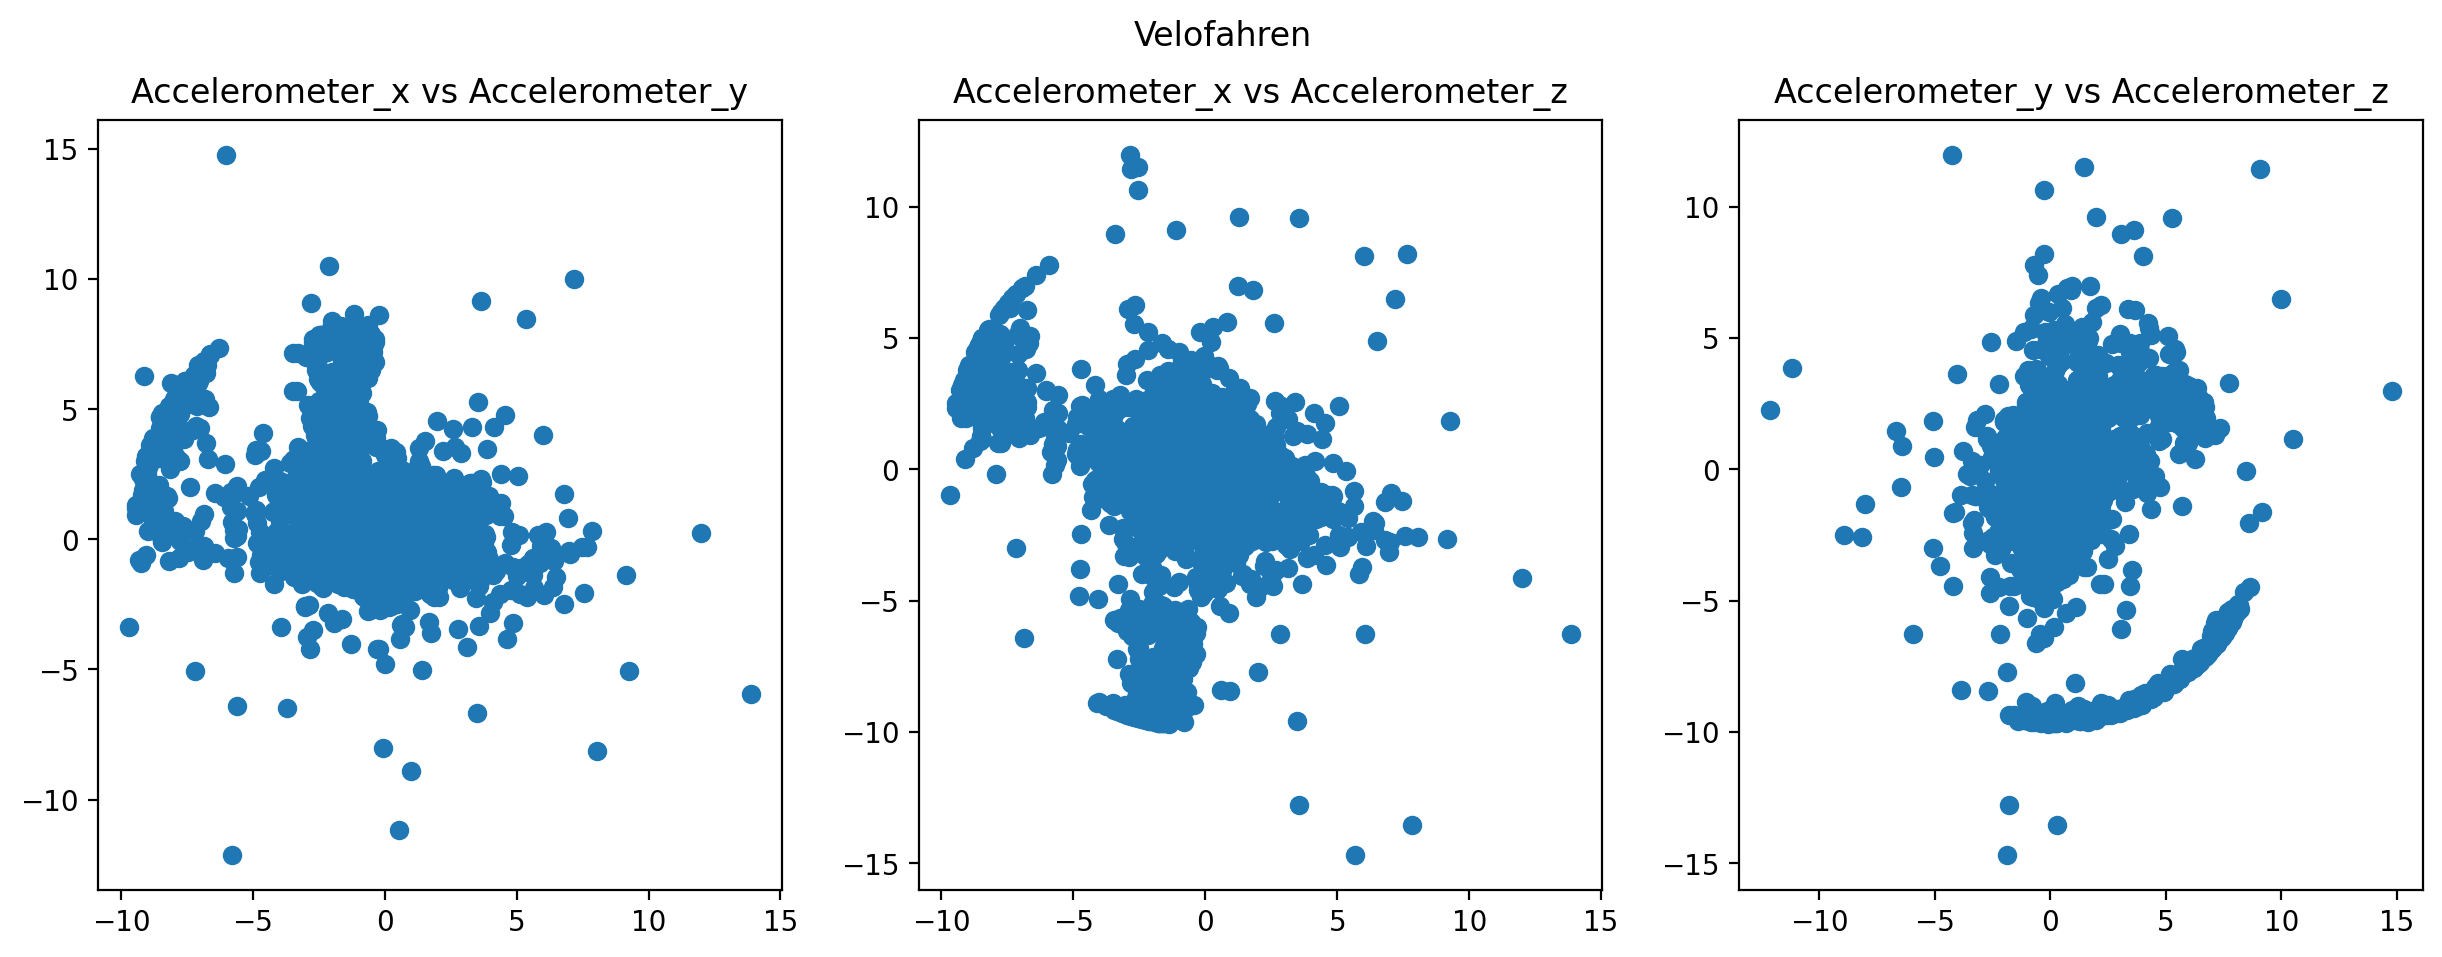

In [ ]:
def plot_scatter(df_input):
    # scatter plot of Accelerometer x, y, z
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].scatter(df_input['Accelerometer_x'], df_input['Accelerometer_y'])
    axs[0].set_title('Accelerometer_x vs Accelerometer_y')

    axs[1].scatter(df_input['Accelerometer_x'], df_input['Accelerometer_z'])
    axs[1].set_title('Accelerometer_x vs Accelerometer_z')

    axs[2].scatter(df_input['Accelerometer_y'], df_input['Accelerometer_z'])
    axs[2].set_title('Accelerometer_y vs Accelerometer_z')

    plt.suptitle(f'{df_input["activity"].unique()[0]}')
    plt.show()

activities_call(activities, df_sample_accelerometer, plot_scatter)

### FFT

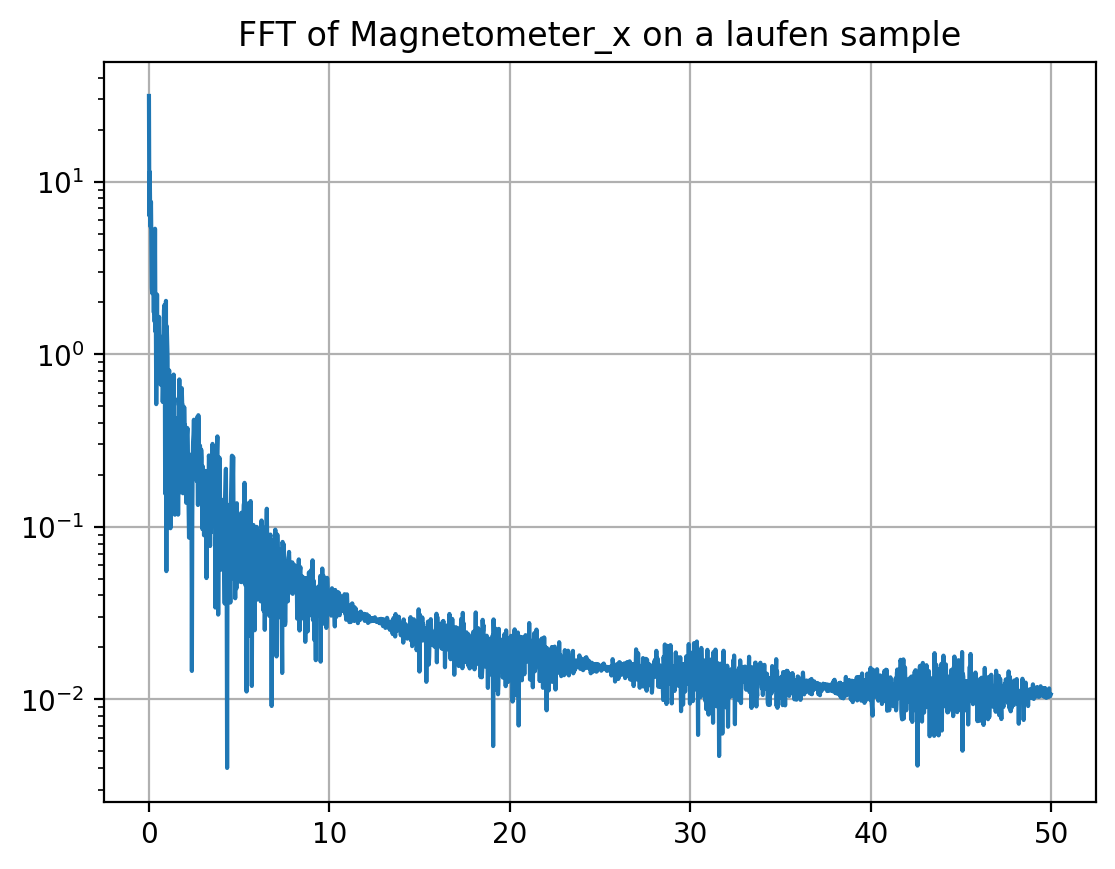

In [45]:
from scipy.fft import fft, fftfreq
import numpy as np

# filter by first hash
hash = df_laufen['hash'].unique()[0]
df_hash = df_laufen[df_laufen['hash'] == hash]

x = df_hash['Magnetometer_x'].values

# sample spacing
T = 1.0 / 100.0
yf = fft(x)
xf = fftfreq(x.size, T)[:x.size//2]

plt.plot(xf, 2.0/x.size * np.abs(yf[0:x.size//2]))

plt.title('FFT of Magnetometer_x on a Laufen sample')

# y axis is log
plt.yscale('log')
plt.grid()
plt.show()